# --

## Setup

* IMPORT

In [1]:
import keras
import numpy as np
from numpy import ma
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import  classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
import random

* Set random state

In [ ]:
random_state = 42

* CHECK FOR GPU

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data 

* LOAD DATA

In [3]:
# Load all data and labels
ccFieldsAll = np.load("C:/Users/mkoli/Syddansk Universitet/Morten Thyrring Stouenberg - Speciale2023/Data/AllNoAlt/ccLastImageNoCloudIndex0_6234.npy", allow_pickle=True)
labels = np.load("C:/Users/mkoli/Syddansk Universitet/Morten Thyrring Stouenberg - Speciale2023/Data/AllNoAlt/reLabelsAll.npy", allow_pickle=True)

# Cloud probability band subset
cloud_probability = ccFieldsAll[:len(labels),:,:,7]

# Subset data to true labels
ccFieldsAll = ccFieldsAll[:len(labels),:,:,[2,1,0]]

* Normalize data to 0-255 range

In [ ]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return (((band-band_min)/((band_max - band_min)))*255)


ccFieldsAll[:,:,:,0] = normalize(ccFieldsAll[:,:,:,0])
ccFieldsAll[:,:,:,1] = normalize(ccFieldsAll[:,:,:,1])
ccFieldsAll[:,:,:,2] = normalize(ccFieldsAll[:,:,:,2])

* cloud masking

In [4]:
# We Set cloud tolerance, between 0-255
cloud_tolerance = 40
    
# We loop in the fields by the length of the dataset
for i in range(len(ccFieldsAll)):
    # we subset the image we are at in the loop
    image = ccFieldsAll[i,:,:,:]    
    # We create and apply a mask based on cloud probability over a certain value
    # We use np.logical because np.where did not work for me at the moment
    mask = np.logical_and(cloud_probability[i, :, :,] >= cloud_tolerance, cloud_probability[i, :, :] <= 256)
    # We set all masked pixels to zero, to black out cloud covered parts
    # I do not know why but it didn't work when i did not make a copy. It is just one of those times. 
    masked = image.copy()
    masked[mask] = 0
    # We are replacing the current image with the one with applied cloud mask, if no clouds then nothing is removed.
    ccFieldsAll[i] = masked

* DELETE EMPTY IMAGES, resize while were at it

In [5]:
# we want to delete the all black images, this is done by only appending images with visible RGB bands not all black.

# Initiate list for images that did not get blacked out as well as a list for labels
ccFieldsNoCloud = []
LabelsNoCloud = []

# as we are looping in the images we resize them at the same time
# so we set the size of the images
size = 128

# We loop in all the images
for i in range(len(ccFieldsAll)):
    # if the image is not all black
    if not np.all(ccFieldsAll[i] == 0):
        #we append the image and label
        ccFieldsNoCloud.append(tf.image.resize(ccFieldsAll[i], [size, size]))
        LabelsNoCloud.append(labels[i])

# We set the lists as arrays
ccFieldsNoCloud = np.array(ccFieldsNoCloud)
LabelsNoCloud   = np.array(LabelsNoCloud)

#And print the shapes to control the output and see how many fields are left. 
print(ccFieldsNoCloud.shape)
print(LabelsNoCloud.shape)

(6122, 128, 128, 3)
(6122,)


* NEW DISTRIBUTION OF LABELS

In [6]:
print(f'Number of observations : {len(LabelsNoCloud)}')

print(f'appearances of 0 in labels : {np.count_nonzero(LabelsNoCloud == 0)}({round(100*np.count_nonzero(LabelsNoCloud == 0)/len(LabelsNoCloud),2)}% of total)')
print(f'appearances of 1 in labels : {np.count_nonzero(LabelsNoCloud == 1)}({round(100*np.count_nonzero(LabelsNoCloud == 1)/len(LabelsNoCloud),2)}% of total)')
print(f'appearances of 2 in labels : {np.count_nonzero(LabelsNoCloud == 2)}({round(100*np.count_nonzero(LabelsNoCloud == 2)/len(LabelsNoCloud),2)}% of total)')

Number of observations : 6122
appearances of 0 in labels : 999(16.32% of total)
appearances of 1 in labels : 1325(21.64% of total)
appearances of 2 in labels : 3798(62.04% of total)


### CNN (RGB images)

In [7]:
# Data is split 80/20 for train and test
X_train, X_test, y_train, y_test = train_test_split(ccFieldsNoCloud, 
                                                    LabelsNoCloud, 
                                                    test_size=0.2, 
                                                    random_state=random_state)

# Train data is split 75/25, which corresponds to 20% of original 
# data as validation and 60% of original data as train
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=random_state) # 0.25 x 0.8 = 0.2

# Print the dataset shapes to inspect sizes
print(X_train.shape, y_train.shape) 
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(3672, 128, 128, 3) (3672,)
(1225, 128, 128, 3) (1225,)
(1225, 128, 128, 3) (1225,)


# Data augmentation

In [8]:
#Defining augmentaation method 
 
datagen = ImageDataGenerator(
    # Rotation range is set to 360 to enable images to get any rotational angle
    rotation_range      = 360,        
    # Zoom range is a conservative 0.2 to not get too big parts of the image out of bounds
    zoom_range          = 0.2,           
    # Brightness range is random between specified values to enable brightness adjustment due to sun or shadow from clouds
    brightness_range    = (0.8,1.2),    
    # Horisontal flip is enabled. I do not know if it is going to make a difference, but it is not going to hurt. 
    horizontal_flip     = True)

In [9]:
# We initiate lists for data and labels used for augmentation
data_for_augmentation = []
labels_for_augmentation = []

# We Loop Loop data and append fields to each class for single class data augmentation 
for i in range(len(y_train)):
  if y_train[i] == 0:
    data_for_augmentation.append(X_train[i])
    labels_for_augmentation.append(y_train[i])
  if y_train[i] == 1:
    data_for_augmentation.append(X_train[i])
    labels_for_augmentation.append(y_train[i])

# save as numpy arrays
data_for_augmentation    = np.asarray(data_for_augmentation)
labels_for_augmentation    = np.asarray(labels_for_augmentation)

# Check  array shape
print(f'data for augmentation : {data_for_augmentation.shape} labels for augmentation : {labels_for_augmentation.shape}')

data for augmentation : (1412, 128, 128, 3) labels for augmentation : (1412,)


In [10]:
# We set a specified number of images for augmentation per image in the dataset
num_samples_per_image = 7
# num_samples_per_image = 9
# num_samples_per_image = 11

# We reshaping data, i am not sure why, but stack overflow helped me get here.
aug_dataset            = data_for_augmentation.reshape(data_for_augmentation.shape[0], 
                                                      data_for_augmentation.shape[1], 
                                                      data_for_augmentation.shape[2], 
                                                      3)

# We initiate a list of labels for augmented data
labels_aug = []
# We create an empty list for the augmented images
augmented_images = []

# We loop in the length of the dataset
for i in range(len(aug_dataset)):
    # We loop in the desired amount of images augmented for each image
    for j in range(num_samples_per_image):
        # we subset the image
        img = data_for_augmentation[i]
        # we expand dimensions as described on the tensorflow website 
        # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator 
        img = np.expand_dims(img, axis=0)
        # We use the datagen.flow to flow one image at the time into the augmenting imagedatagenerator
        # I am not entirely sure about the .next when using only one image but it works, in theory we do not need it but i do not want to remove something when it works. 
        augmented_img = datagen.flow(img, batch_size=1, shuffle=False).next()
        #as we have expanded the dimensiong we need to sqeeze it all back together for a functioning image again
        augmented_img = augmented_img.squeeze(axis=0)
        # We append the image and labels to our lists
        augmented_images.append(augmented_img)
        labels_aug.append(labels_for_augmentation[i])

#Turn it all into numpy arrays
labels_aug=np.asarray(labels_aug)
augmented_images=np.asarray(augmented_images)

In [11]:
# We concatenate the data to make sure the training dataset is now the original train data and the augmented data
X_train = np.concatenate((X_train, augmented_images), axis=0)
y_train = np.concatenate((y_train, labels_aug), axis=0)

In [ ]:
# We shuffle the data to ensure there is not only accepted fields in the start of the dataset
# we set a list of indexes that is randomly shuffled
idx = np.random.permutation(len(X_train))
# We use these indexes to set the images with corresponding labels
X_trainx,y_train = X_train[idx], y_train[idx]

In [12]:
print(f'Number of observations : {len(y_train)}')

print(f'appearances of 0 in labels : {np.count_nonzero(y_train == 0)}({round(100*np.count_nonzero(y_train == 0)/len(y_train),2)}% of total)')
print(f'appearances of 1 in labels : {np.count_nonzero(y_train == 1)}({round(100*np.count_nonzero(y_train == 1)/len(y_train),2)}% of total)')
print(f'appearances of 2 in labels : {np.count_nonzero(y_train == 2)}({round(100*np.count_nonzero(y_train == 2)/len(y_train),2)}% of total)')

Number of observations : 13556
appearances of 0 in labels : 4832(35.64% of total)
appearances of 1 in labels : 6464(47.68% of total)
appearances of 2 in labels : 2260(16.67% of total)


# Deep Learning Models

In [13]:
X_train = tf.keras.applications.resnet_v2.preprocess_input(X_train, data_format=None)
X_test = tf.keras.applications.resnet_v2.preprocess_input(X_test, data_format=None)
X_val = tf.keras.applications.resnet_v2.preprocess_input(X_val, data_format=None)

# ResNet50V2 - Hyperparametersearch

In [ ]:
def His_metrics(history, cp_filepath):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(f'Training and Validation Loss {cp_filepath}')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(f'Training and Validation Loss {cp_filepath}')
    plt.xlabel('epoch')
    plt.show()

def Viz_metrics(X_test, y_test, model, cp_filepath):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(classification_report(y_test, y_pred_classes))
    cm = confusion_matrix(y_test, y_pred_classes)
    class_names = ['Failed (0)', 'Partially (1)', 'Accepted (2)']
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap=plt.cm.OrRd)
    plt.title(f'Confusion Matrix \n {cp_filepath}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.colorbar()
    for k in range(len(class_names)):
        for h in range(len(class_names)):
            plt.text(h, k, cm[k, h], ha='center', va='center', color='black')

    plt.show()        


In [14]:
histories = []
name = []

ft_histories = []
ft_name = []

### For 0.0001 learning rate 

Running 6 possible models with learning rates:[0.0001] and batch sizes: [64, 32, 16] with dropouts: [0.2, 0.5] for epochs: 100
Running: 
 learning rate:0.0001, batch size: 64 with dropout: 0.2 for epochs: 100
Epoch 1/100
212/212 [==============================] - 18s 51ms/step - loss: 2.2447 - accuracy: 0.4594 - val_loss: 1.3795 - val_accuracy: 0.4873
Epoch 2/100
212/212 [==============================] - 10s 46ms/step - loss: 1.1217 - accuracy: 0.5412 - val_loss: 1.2493 - val_accuracy: 0.4776
Epoch 3/100
212/212 [==============================] - 10s 46ms/step - loss: 0.8846 - accuracy: 0.5823 - val_loss: 0.9949 - val_accuracy: 0.5755
Epoch 4/100
212/212 [==============================] - 10s 45ms/step - loss: 0.7765 - accuracy: 0.6258 - val_loss: 1.0579 - val_accuracy: 0.5722
Epoch 5/100
212/212 [==============================] - 10s 45ms/step - loss: 0.7182 - accuracy: 0.6586 - val_loss: 1.2888 - val_accuracy: 0.4694
Epoch 6/100
212/212 [==============================] - 10s 46ms/st

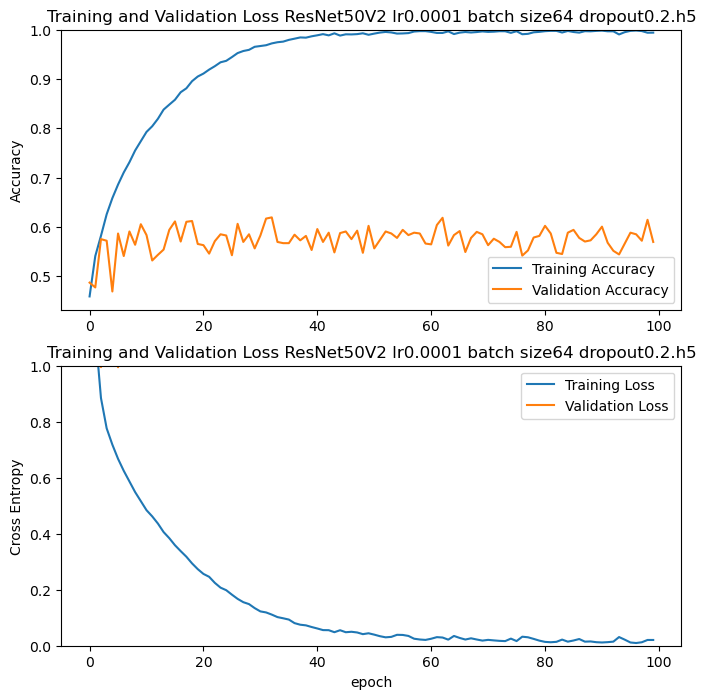

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.48      0.47      0.47       208
           1       0.30      0.42      0.35       250
           2       0.80      0.70      0.75       767

    accuracy                           0.60      1225
   macro avg       0.53      0.53      0.52      1225
weighted avg       0.64      0.60      0.62      1225



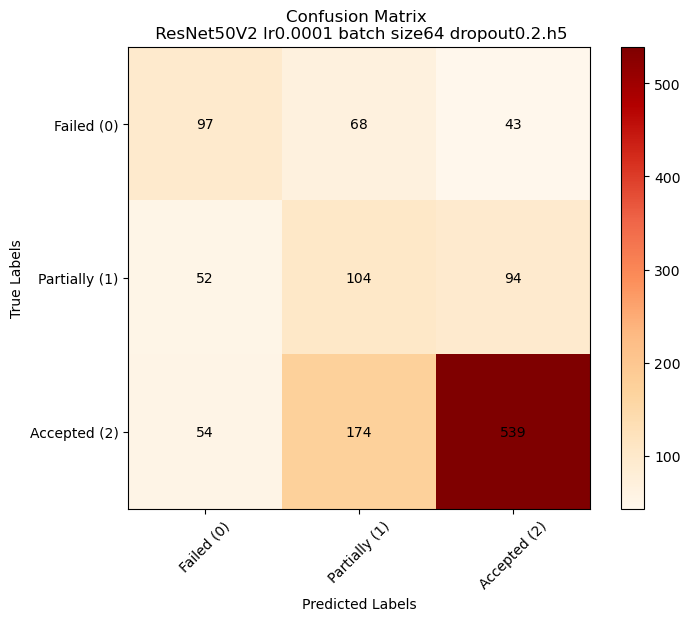

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_______________________________________

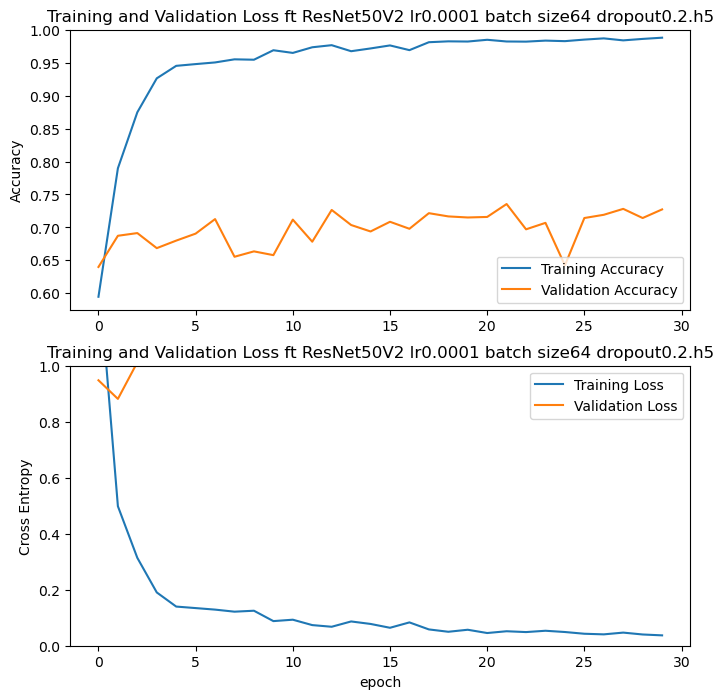

39/39 [==============================] - 2s 21ms/step
              precision    recall  f1-score   support

           0       0.72      0.60      0.66       208
           1       0.47      0.33      0.39       250
           2       0.80      0.91      0.85       767

    accuracy                           0.74      1225
   macro avg       0.66      0.61      0.63      1225
weighted avg       0.72      0.74      0.72      1225



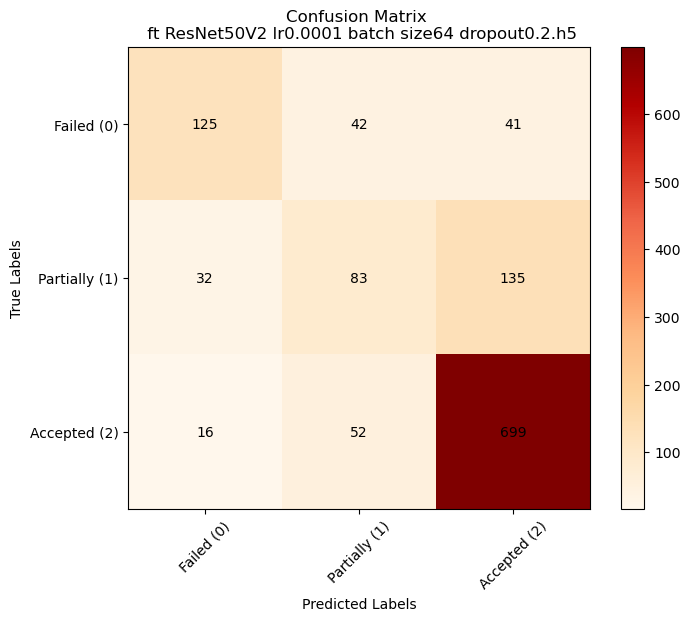

Running: 
 learning rate:0.0001, batch size: 64 with dropout: 0.5 for epochs: 100
Epoch 1/100
212/212 [==============================] - 12s 50ms/step - loss: 2.5702 - accuracy: 0.4501 - val_loss: 1.4354 - val_accuracy: 0.4090
Epoch 2/100
212/212 [==============================] - 10s 47ms/step - loss: 1.0791 - accuracy: 0.5147 - val_loss: 1.1906 - val_accuracy: 0.4139
Epoch 3/100
212/212 [==============================] - 10s 47ms/step - loss: 0.9148 - accuracy: 0.5479 - val_loss: 1.2528 - val_accuracy: 0.4220
Epoch 4/100
212/212 [==============================] - 10s 46ms/step - loss: 0.8514 - accuracy: 0.5806 - val_loss: 1.1476 - val_accuracy: 0.4416
Epoch 5/100
212/212 [==============================] - 10s 47ms/step - loss: 0.8153 - accuracy: 0.5985 - val_loss: 1.0285 - val_accuracy: 0.5061
Epoch 6/100
212/212 [==============================] - 10s 46ms/step - loss: 0.7775 - accuracy: 0.6199 - val_loss: 1.0683 - val_accuracy: 0.5135
Epoch 7/100
212/212 [===========================

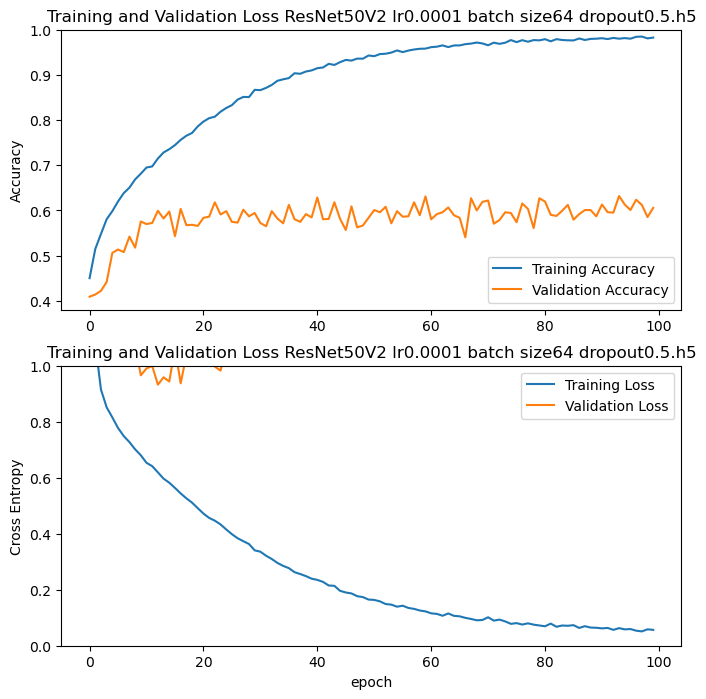

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.44      0.53      0.48       208
           1       0.31      0.40      0.35       250
           2       0.82      0.69      0.75       767

    accuracy                           0.60      1225
   macro avg       0.52      0.54      0.53      1225
weighted avg       0.65      0.60      0.62      1225



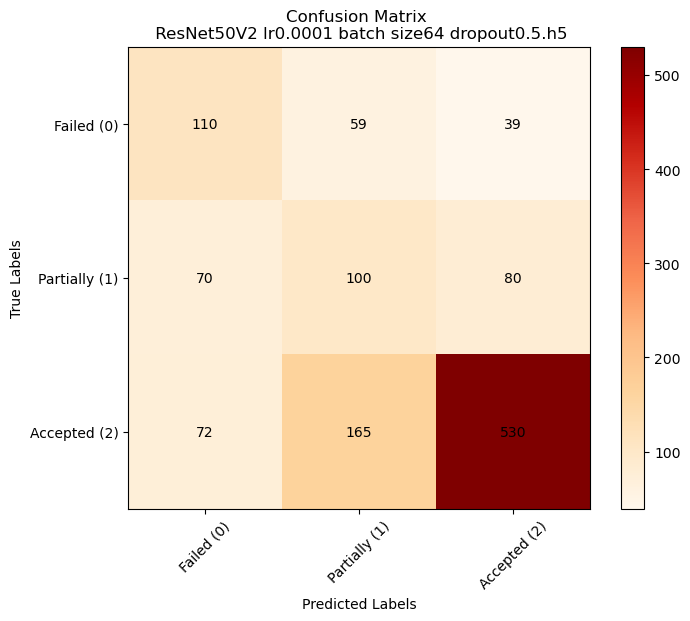

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

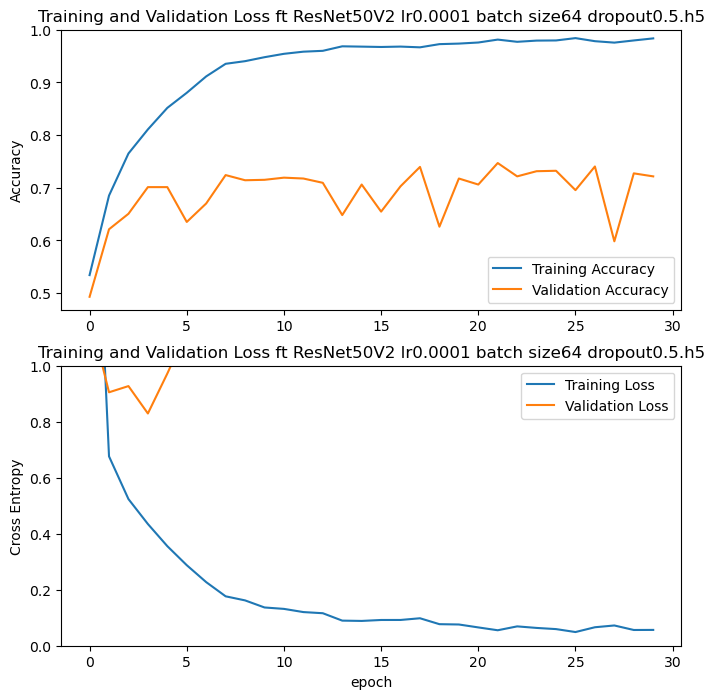

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.77      0.58      0.66       208
           1       0.46      0.43      0.45       250
           2       0.81      0.88      0.84       767

    accuracy                           0.74      1225
   macro avg       0.68      0.63      0.65      1225
weighted avg       0.73      0.74      0.73      1225



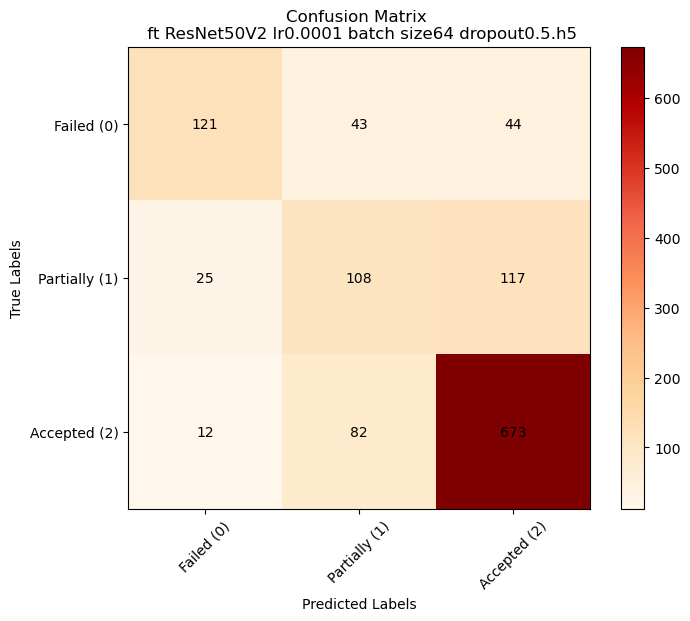

Running: 
 learning rate:0.0001, batch size: 32 with dropout: 0.2 for epochs: 100
Epoch 1/100
424/424 [==============================] - 14s 28ms/step - loss: 1.7679 - accuracy: 0.4852 - val_loss: 1.4194 - val_accuracy: 0.4367
Epoch 2/100
424/424 [==============================] - 11s 27ms/step - loss: 0.9374 - accuracy: 0.5682 - val_loss: 1.0461 - val_accuracy: 0.5567
Epoch 3/100
424/424 [==============================] - 11s 26ms/step - loss: 0.7906 - accuracy: 0.6219 - val_loss: 1.1366 - val_accuracy: 0.5184
Epoch 4/100
424/424 [==============================] - 11s 26ms/step - loss: 0.7194 - accuracy: 0.6576 - val_loss: 1.0941 - val_accuracy: 0.5355
Epoch 5/100
424/424 [==============================] - 12s 28ms/step - loss: 0.6570 - accuracy: 0.6926 - val_loss: 0.9626 - val_accuracy: 0.5918
Epoch 6/100
424/424 [==============================] - 11s 27ms/step - loss: 0.6107 - accuracy: 0.7215 - val_loss: 1.0331 - val_accuracy: 0.5951
Epoch 7/100
424/424 [===========================

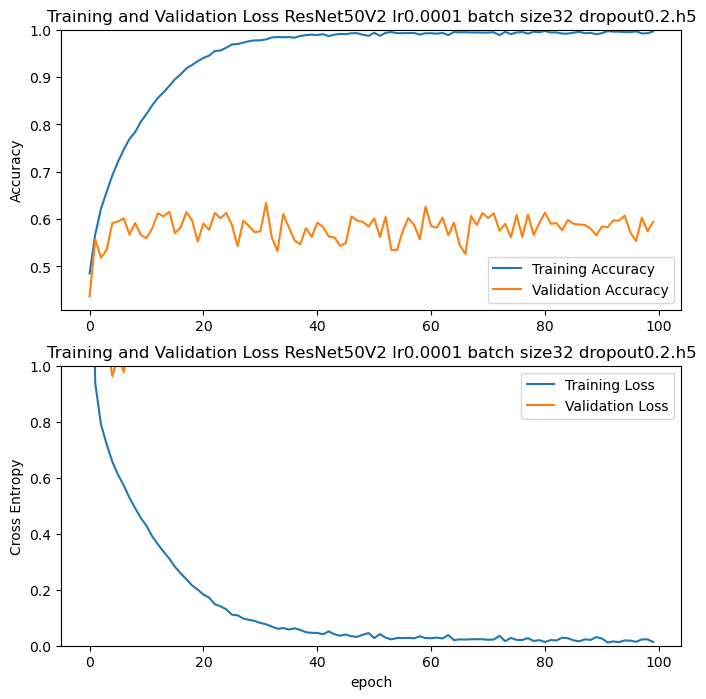

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.48      0.47      0.47       208
           1       0.32      0.41      0.36       250
           2       0.80      0.73      0.76       767

    accuracy                           0.62      1225
   macro avg       0.53      0.54      0.53      1225
weighted avg       0.65      0.62      0.63      1225



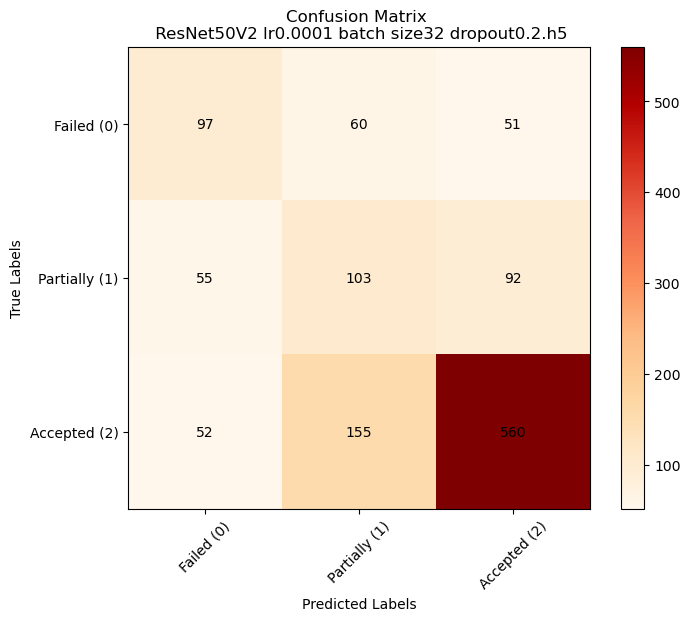

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

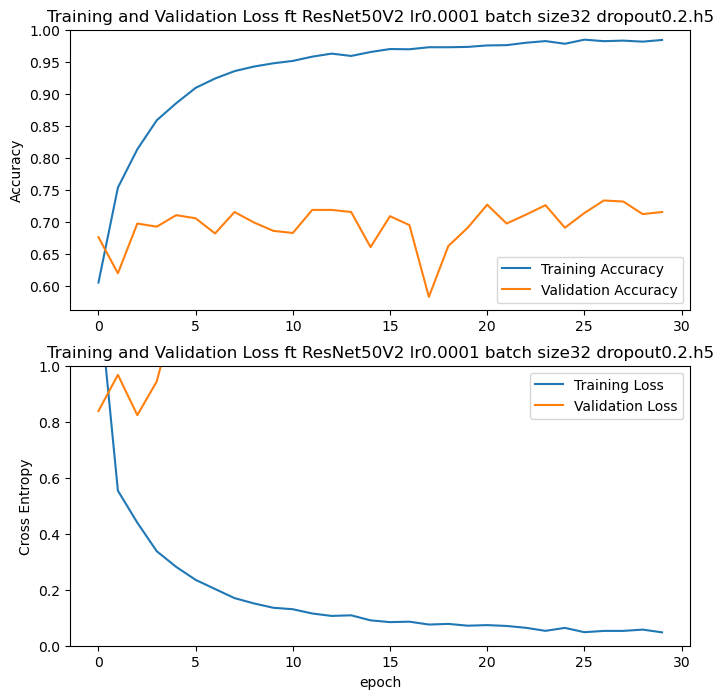

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.78      0.51      0.62       208
           1       0.45      0.57      0.50       250
           2       0.84      0.84      0.84       767

    accuracy                           0.73      1225
   macro avg       0.69      0.64      0.65      1225
weighted avg       0.75      0.73      0.73      1225



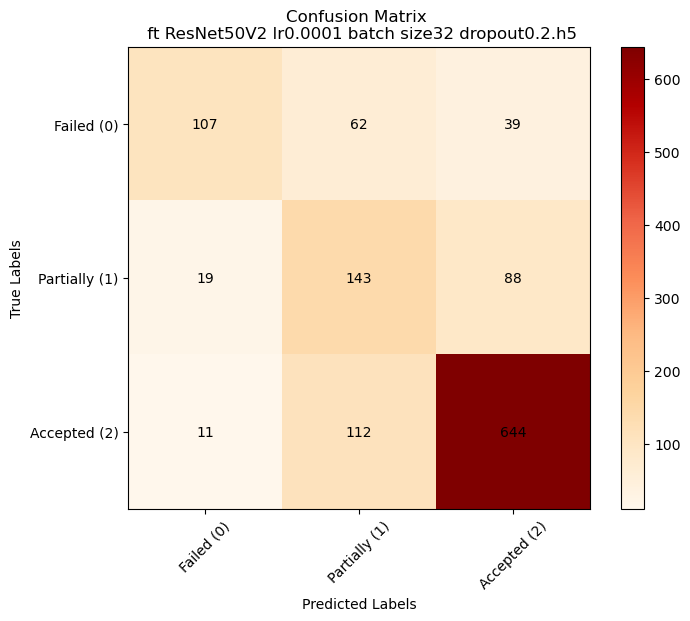

Running: 
 learning rate:0.0001, batch size: 32 with dropout: 0.5 for epochs: 100
Epoch 1/100
424/424 [==============================] - 14s 28ms/step - loss: 2.1048 - accuracy: 0.4596 - val_loss: 1.2530 - val_accuracy: 0.4865
Epoch 2/100
424/424 [==============================] - 11s 26ms/step - loss: 0.9731 - accuracy: 0.5328 - val_loss: 1.1470 - val_accuracy: 0.4473
Epoch 3/100
424/424 [==============================] - 11s 25ms/step - loss: 0.8719 - accuracy: 0.5719 - val_loss: 1.1054 - val_accuracy: 0.4800
Epoch 4/100
424/424 [==============================] - 11s 26ms/step - loss: 0.8228 - accuracy: 0.5962 - val_loss: 1.0984 - val_accuracy: 0.5200
Epoch 5/100
424/424 [==============================] - 11s 25ms/step - loss: 0.7877 - accuracy: 0.6171 - val_loss: 1.1241 - val_accuracy: 0.4996
Epoch 6/100
424/424 [==============================] - 11s 26ms/step - loss: 0.7526 - accuracy: 0.6364 - val_loss: 1.0263 - val_accuracy: 0.5371
Epoch 7/100
424/424 [===========================

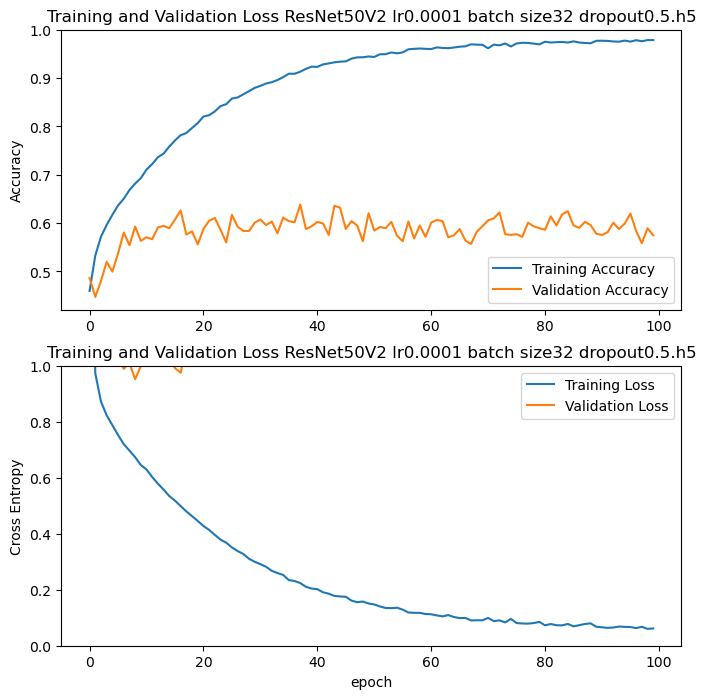

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.43      0.53      0.48       208
           1       0.31      0.38      0.34       250
           2       0.82      0.70      0.76       767

    accuracy                           0.61      1225
   macro avg       0.52      0.54      0.52      1225
weighted avg       0.65      0.61      0.62      1225



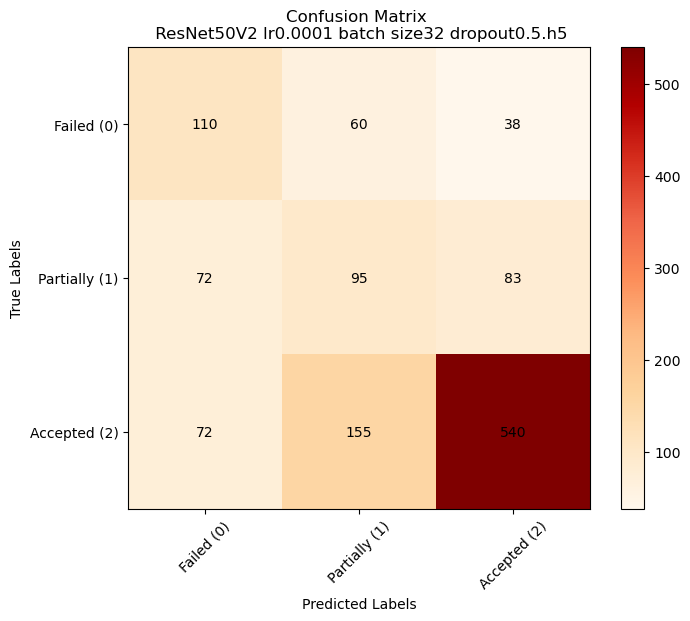

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_3 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

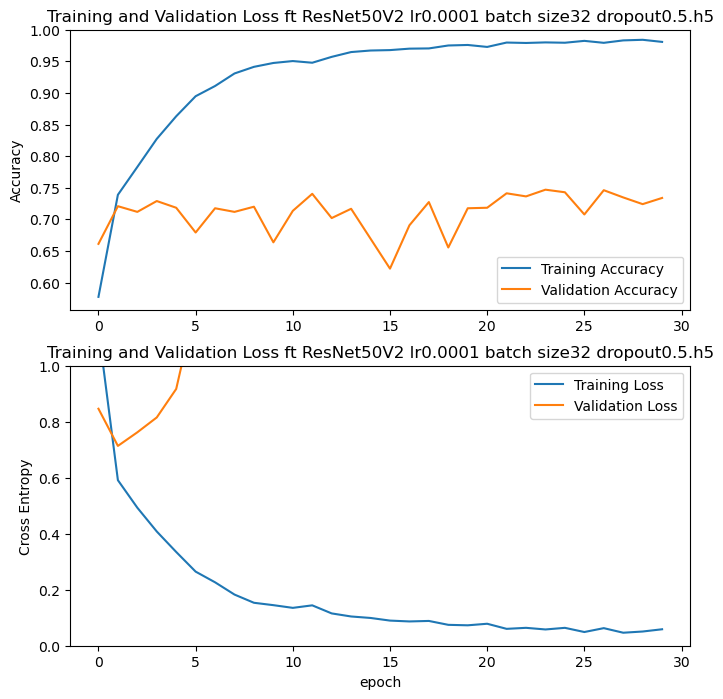

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       208
           1       0.55      0.38      0.45       250
           2       0.82      0.91      0.86       767

    accuracy                           0.76      1225
   macro avg       0.69      0.65      0.67      1225
weighted avg       0.74      0.76      0.75      1225



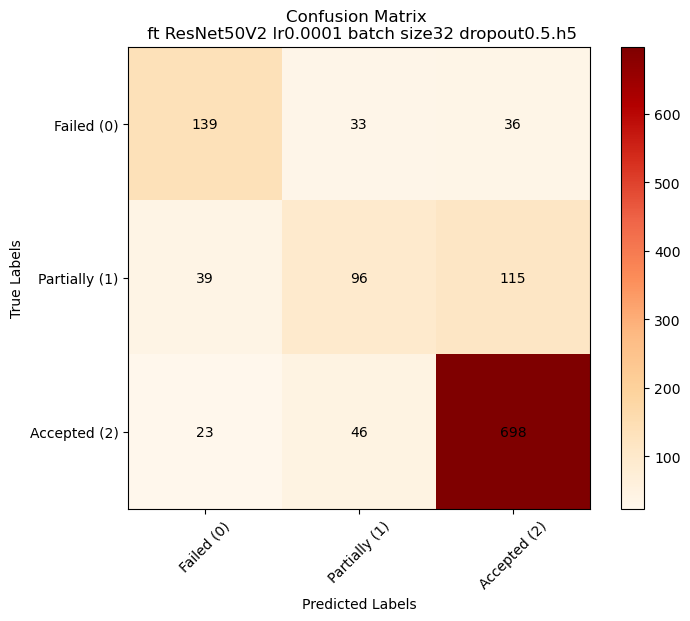

Running: 
 learning rate:0.0001, batch size: 16 with dropout: 0.2 for epochs: 100
Epoch 1/100
848/848 [==============================] - 16s 17ms/step - loss: 1.5942 - accuracy: 0.4941 - val_loss: 1.0593 - val_accuracy: 0.5404
Epoch 2/100
848/848 [==============================] - 14s 16ms/step - loss: 0.8628 - accuracy: 0.5738 - val_loss: 1.0553 - val_accuracy: 0.5494
Epoch 3/100
848/848 [==============================] - 14s 16ms/step - loss: 0.7586 - accuracy: 0.6359 - val_loss: 0.9226 - val_accuracy: 0.6302
Epoch 4/100
848/848 [==============================] - 14s 16ms/step - loss: 0.6922 - accuracy: 0.6707 - val_loss: 1.0541 - val_accuracy: 0.5273
Epoch 5/100
848/848 [==============================] - 14s 16ms/step - loss: 0.6396 - accuracy: 0.7078 - val_loss: 1.0459 - val_accuracy: 0.5739
Epoch 6/100
848/848 [==============================] - 14s 16ms/step - loss: 0.5912 - accuracy: 0.7316 - val_loss: 1.0927 - val_accuracy: 0.5698
Epoch 7/100
848/848 [===========================

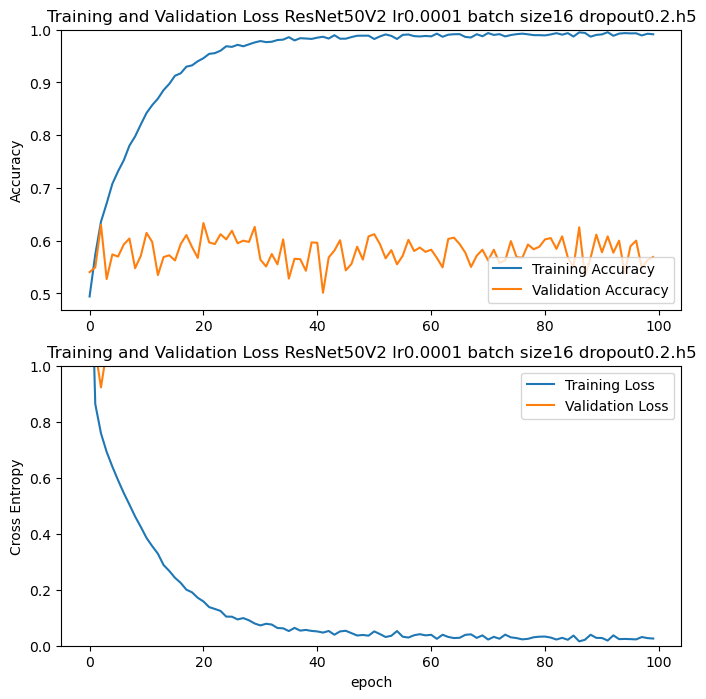

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.40      0.47      0.43       208
           1       0.29      0.32      0.30       250
           2       0.80      0.74      0.77       767

    accuracy                           0.61      1225
   macro avg       0.50      0.51      0.50      1225
weighted avg       0.63      0.61      0.62      1225



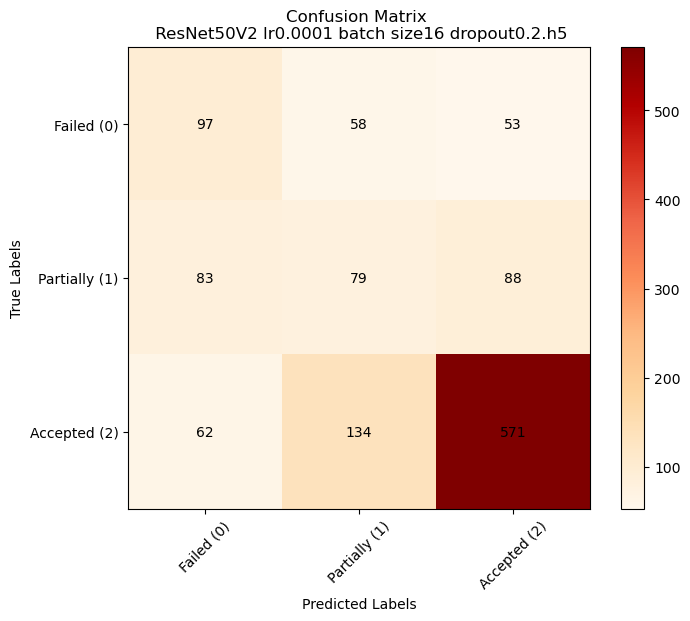

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_4 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

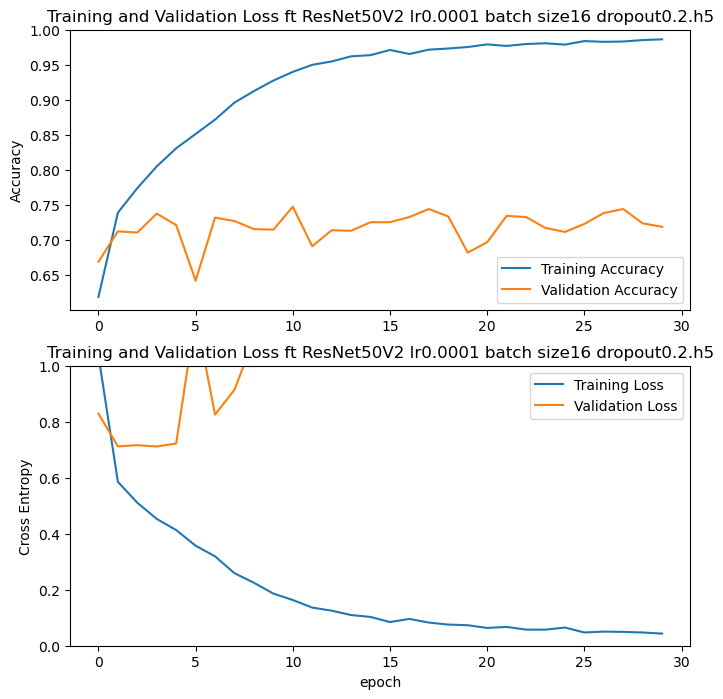

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.71      0.66      0.69       208
           1       0.45      0.52      0.49       250
           2       0.85      0.83      0.84       767

    accuracy                           0.74      1225
   macro avg       0.67      0.67      0.67      1225
weighted avg       0.75      0.74      0.74      1225



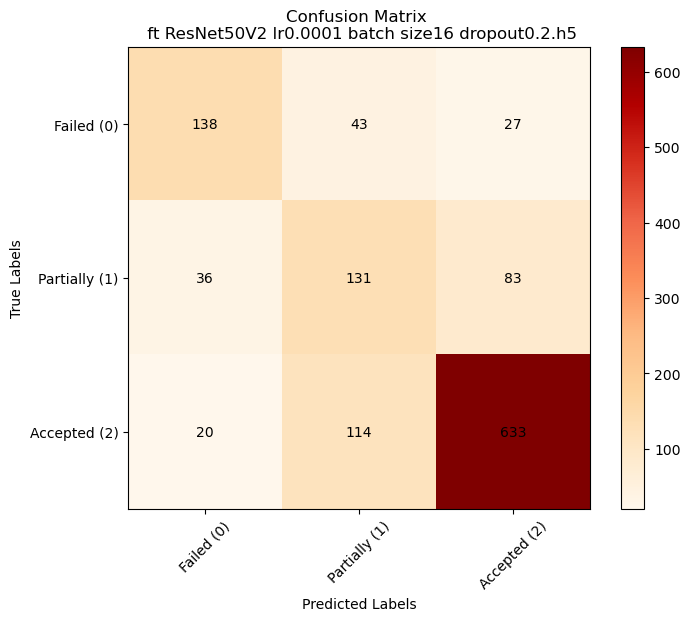

Running: 
 learning rate:0.0001, batch size: 16 with dropout: 0.5 for epochs: 100
Epoch 1/100
848/848 [==============================] - 16s 17ms/step - loss: 1.8145 - accuracy: 0.4706 - val_loss: 1.0648 - val_accuracy: 0.4816
Epoch 2/100
848/848 [==============================] - 14s 16ms/step - loss: 0.9268 - accuracy: 0.5443 - val_loss: 0.9597 - val_accuracy: 0.5682
Epoch 3/100
848/848 [==============================] - 14s 16ms/step - loss: 0.8509 - accuracy: 0.5758 - val_loss: 1.0472 - val_accuracy: 0.5184
Epoch 4/100
848/848 [==============================] - 14s 16ms/step - loss: 0.8008 - accuracy: 0.6110 - val_loss: 1.2629 - val_accuracy: 0.3992
Epoch 5/100
848/848 [==============================] - 14s 16ms/step - loss: 0.7677 - accuracy: 0.6258 - val_loss: 0.9700 - val_accuracy: 0.5698
Epoch 6/100
848/848 [==============================] - 14s 16ms/step - loss: 0.7378 - accuracy: 0.6461 - val_loss: 1.0240 - val_accuracy: 0.5837
Epoch 7/100
848/848 [===========================

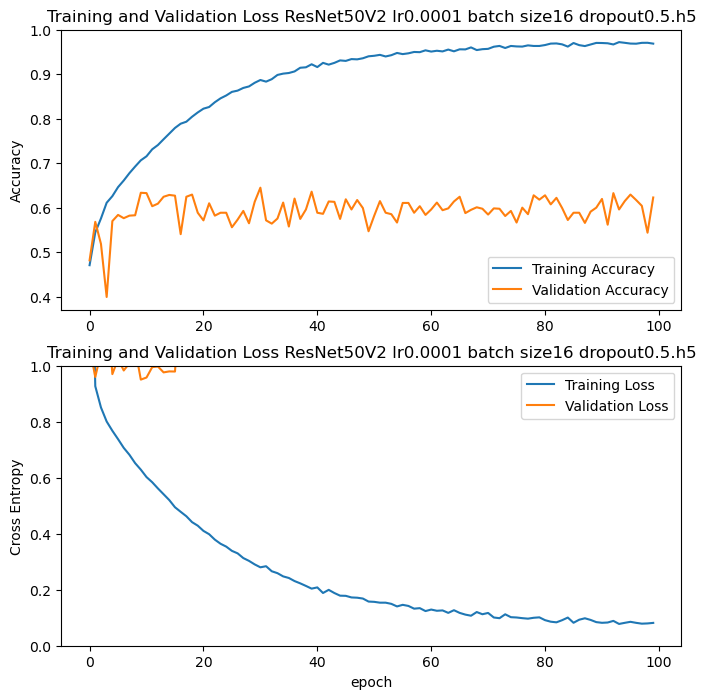

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.47      0.50      0.48       208
           1       0.35      0.50      0.41       250
           2       0.82      0.70      0.76       767

    accuracy                           0.62      1225
   macro avg       0.55      0.56      0.55      1225
weighted avg       0.67      0.62      0.64      1225



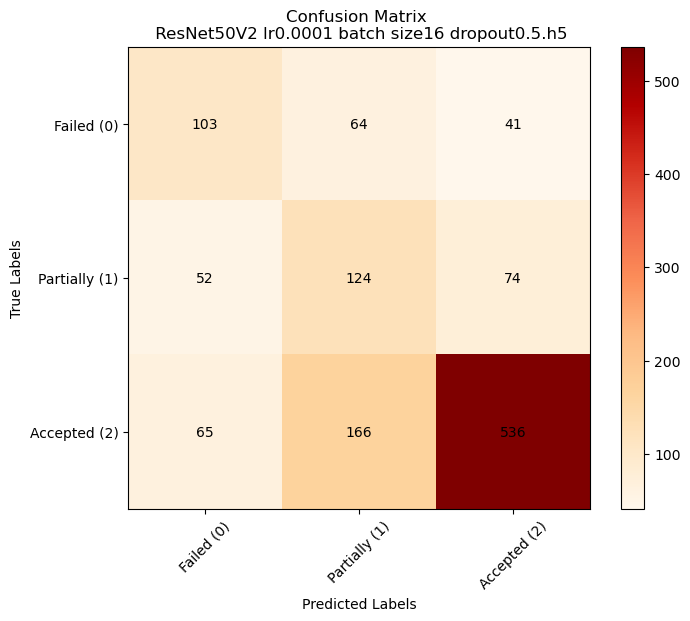

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_5 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

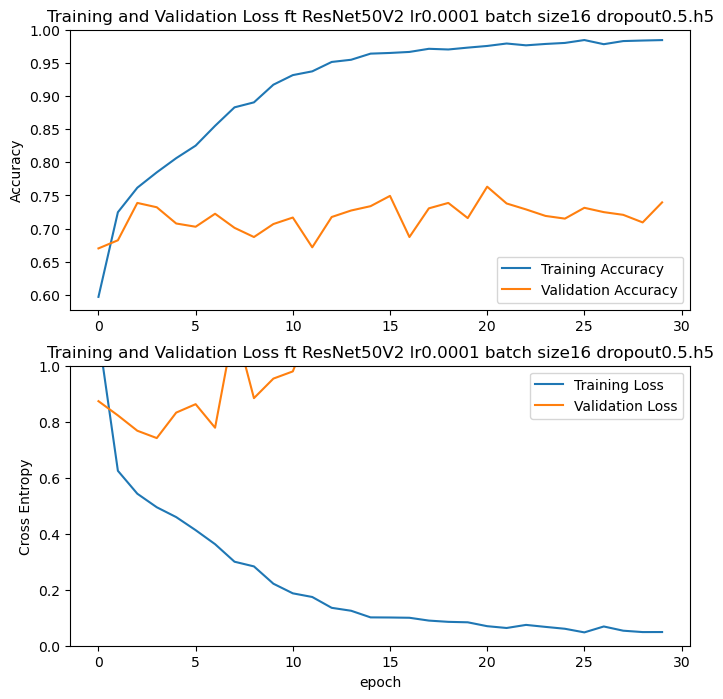

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       208
           1       0.50      0.47      0.48       250
           2       0.83      0.89      0.86       767

    accuracy                           0.76      1225
   macro avg       0.69      0.66      0.67      1225
weighted avg       0.75      0.76      0.75      1225



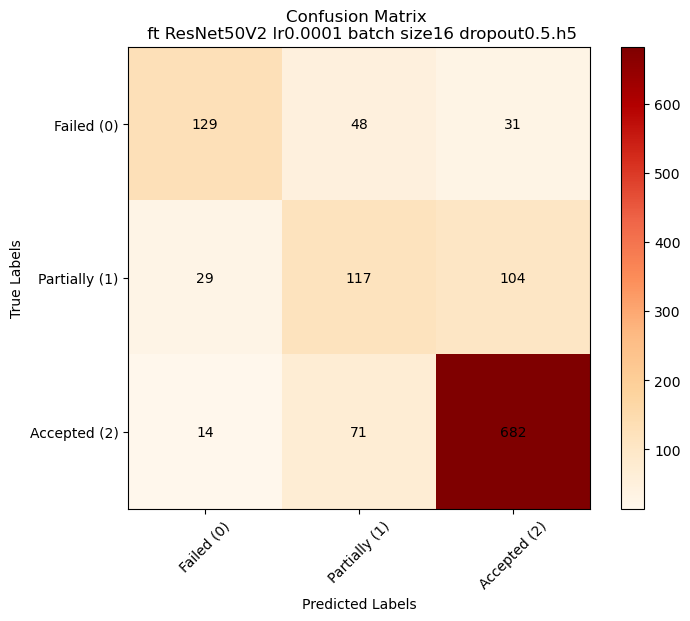

In [15]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.0001]
batch_size = [64,32,16]
dropouts = [0.2, 0.5]

####################################################################################################################
#           We define our model specific parameters

model_name = "ResNet50V2" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running {len(learning_rate)*len(batch_size)*len(dropouts)} possible models with learning rates:{learning_rate} and batch sizes: {batch_size} with dropouts: {dropouts} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
        for d in dropouts:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} with dropout: {d} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.ResNet50V2(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalMaxPool2D(),
                tf.keras.layers.Dense(512, activation='relu'),  
                tf.keras.layers.Dropout(d),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)  

            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)  

In [22]:
print(history.params)

{'verbose': 1, 'epochs': 100, 'steps': 212}


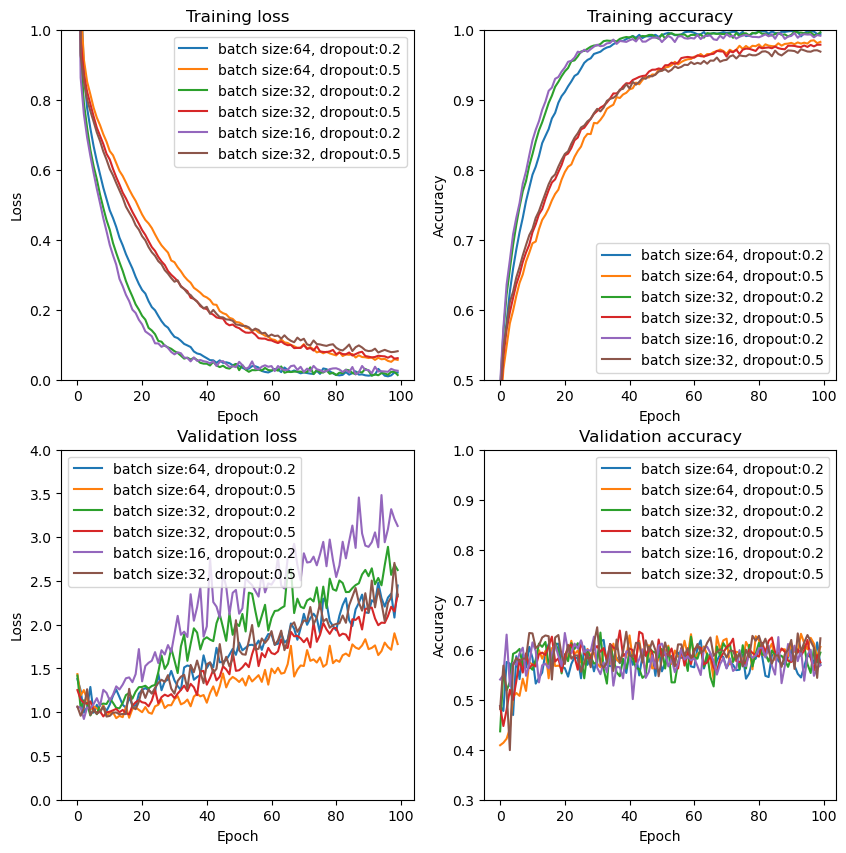

In [26]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(histories[0].history['loss'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['loss'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['loss'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['loss'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['loss'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['loss'], label='batch size:32, dropout:0.5')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(histories[0].history['accuracy'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['accuracy'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['accuracy'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['accuracy'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['accuracy'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['accuracy'], label='batch size:32, dropout:0.5')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(histories[0].history['val_loss'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['val_loss'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['val_loss'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['val_loss'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['val_loss'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['val_loss'], label='batch size:32, dropout:0.5')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(histories[0].history['val_accuracy'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['val_accuracy'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['val_accuracy'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['val_accuracy'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['val_accuracy'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['val_accuracy'], label='batch size:32, dropout:0.5')
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

plt.savefig('top_layer_metrics.png')
plt.show()

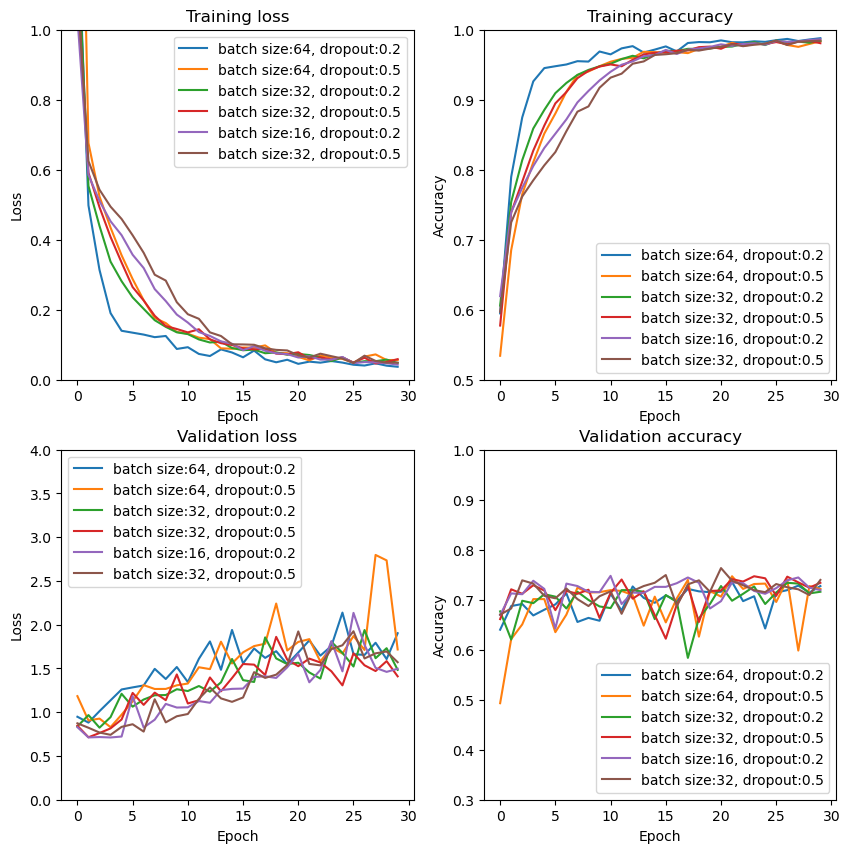

In [27]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(ft_histories[0].history['loss'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['loss'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['loss'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['loss'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['loss'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['loss'], label='batch size:32, dropout:0.5')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(ft_histories[0].history['accuracy'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['accuracy'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['accuracy'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['accuracy'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['accuracy'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['accuracy'], label='batch size:32, dropout:0.5')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(ft_histories[0].history['val_loss'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['val_loss'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['val_loss'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['val_loss'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['val_loss'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['val_loss'], label='batch size:32, dropout:0.5')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(ft_histories[0].history['val_accuracy'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['val_accuracy'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['val_accuracy'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['val_accuracy'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['val_accuracy'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['val_accuracy'], label='batch size:32, dropout:0.5')
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

plt.savefig('fintuned_metrics.png')
plt.show()

### For 0.001 learning rate

Running 6 possible models with learning rates:[0.001] and batch sizes: [64, 32, 16] with dropouts: [0.2, 0.5] for epochs: 100
Running: 
 learning rate:0.001, batch size: 64 with dropout: 0.2 for epochs: 100
Epoch 1/100
212/212 [==============================] - 18s 52ms/step - loss: 1.5339 - accuracy: 0.5038 - val_loss: 0.9287 - val_accuracy: 0.5829
Epoch 2/100
212/212 [==============================] - 10s 46ms/step - loss: 0.8185 - accuracy: 0.5947 - val_loss: 0.9482 - val_accuracy: 0.5771
Epoch 3/100
212/212 [==============================] - 10s 46ms/step - loss: 0.7697 - accuracy: 0.6244 - val_loss: 1.3329 - val_accuracy: 0.4098
Epoch 4/100
212/212 [==============================] - 10s 47ms/step - loss: 0.7221 - accuracy: 0.6518 - val_loss: 0.9045 - val_accuracy: 0.6196
Epoch 5/100
212/212 [==============================] - 10s 47ms/step - loss: 0.6939 - accuracy: 0.6649 - val_loss: 0.8837 - val_accuracy: 0.6588
Epoch 6/100
212/212 [==============================] - 10s 47ms/step

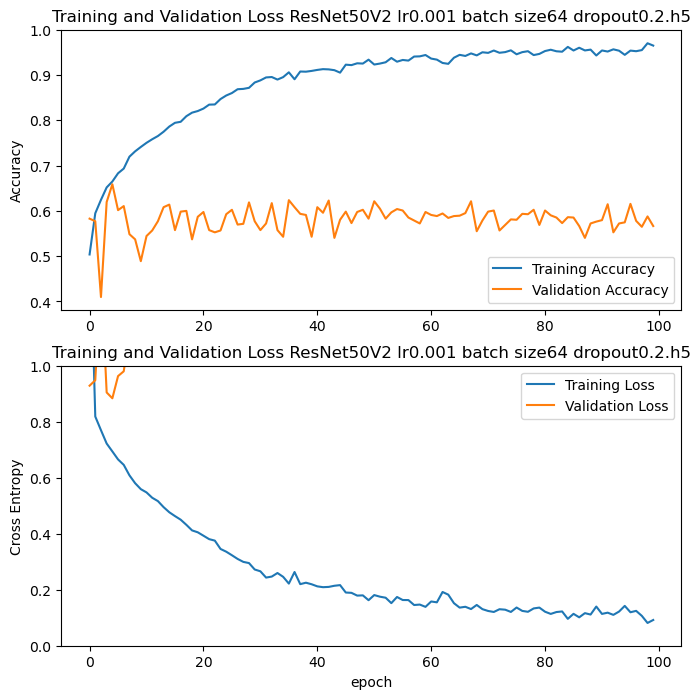

39/39 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.49      0.44      0.47       208
           1       0.33      0.30      0.31       250
           2       0.78      0.83      0.80       767

    accuracy                           0.65      1225
   macro avg       0.53      0.52      0.53      1225
weighted avg       0.64      0.65      0.64      1225



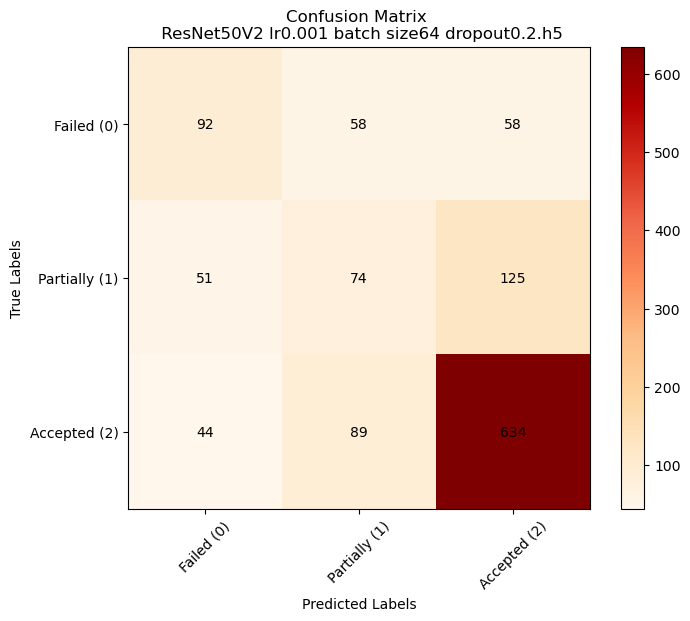

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_______________________________________

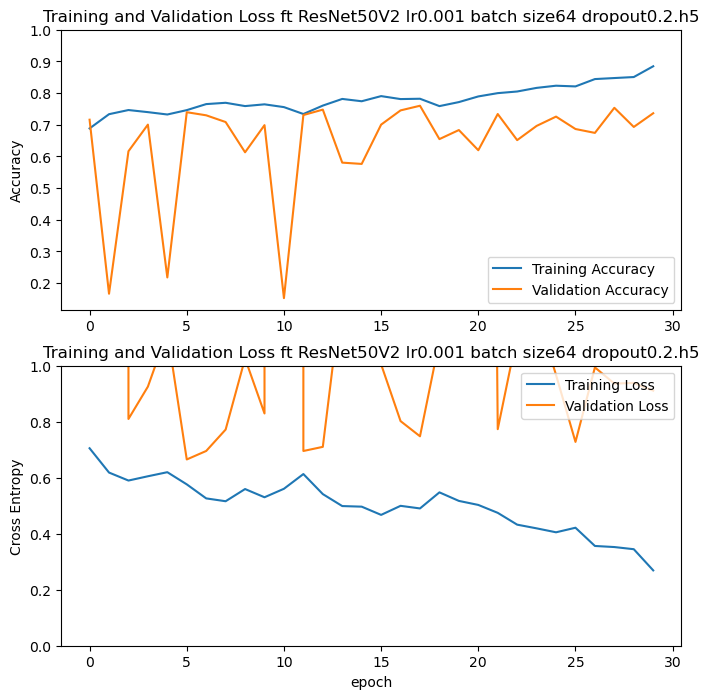

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       208
           1       0.58      0.24      0.34       250
           2       0.78      0.95      0.86       767

    accuracy                           0.76      1225
   macro avg       0.70      0.62      0.64      1225
weighted avg       0.73      0.76      0.73      1225



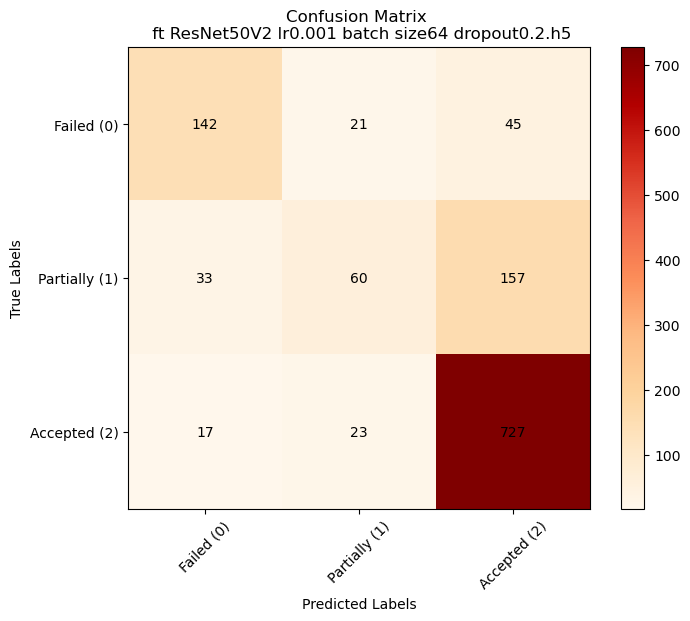

Running: 
 learning rate:0.001, batch size: 64 with dropout: 0.5 for epochs: 100
Epoch 1/100
212/212 [==============================] - 13s 51ms/step - loss: 1.7589 - accuracy: 0.4922 - val_loss: 1.1259 - val_accuracy: 0.4800
Epoch 2/100
212/212 [==============================] - 10s 46ms/step - loss: 0.8789 - accuracy: 0.5513 - val_loss: 1.1355 - val_accuracy: 0.4759
Epoch 3/100
212/212 [==============================] - 10s 47ms/step - loss: 0.8494 - accuracy: 0.5685 - val_loss: 0.9442 - val_accuracy: 0.5747
Epoch 4/100
212/212 [==============================] - 10s 46ms/step - loss: 0.8175 - accuracy: 0.5902 - val_loss: 0.9774 - val_accuracy: 0.5567
Epoch 5/100
212/212 [==============================] - 10s 46ms/step - loss: 0.8104 - accuracy: 0.5921 - val_loss: 1.1564 - val_accuracy: 0.4563
Epoch 6/100
212/212 [==============================] - 10s 47ms/step - loss: 0.7878 - accuracy: 0.6031 - val_loss: 0.9979 - val_accuracy: 0.5837
Epoch 7/100
212/212 [============================

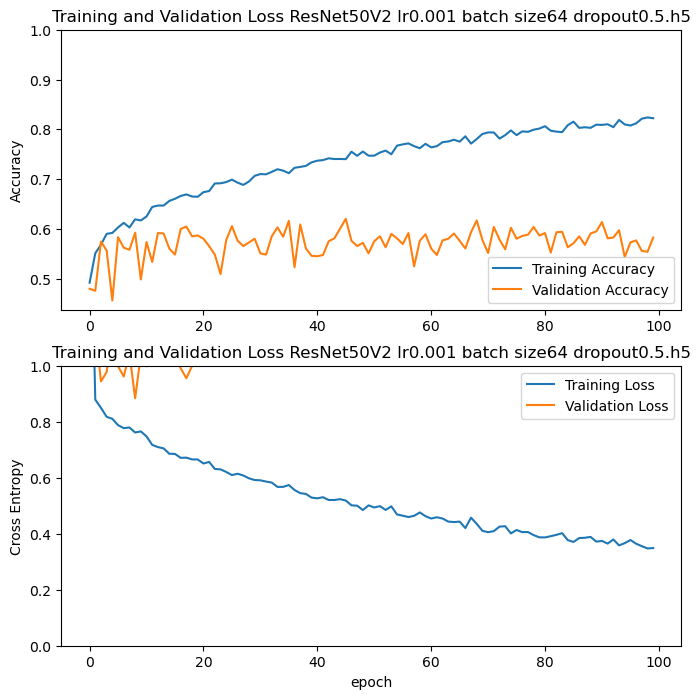

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.49      0.44      0.46       208
           1       0.32      0.58      0.42       250
           2       0.84      0.65      0.73       767

    accuracy                           0.60      1225
   macro avg       0.55      0.56      0.54      1225
weighted avg       0.68      0.60      0.62      1225



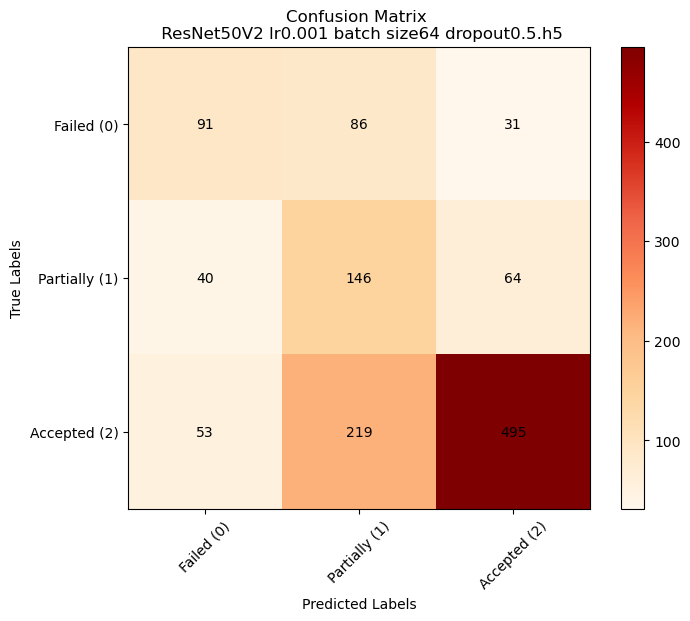

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

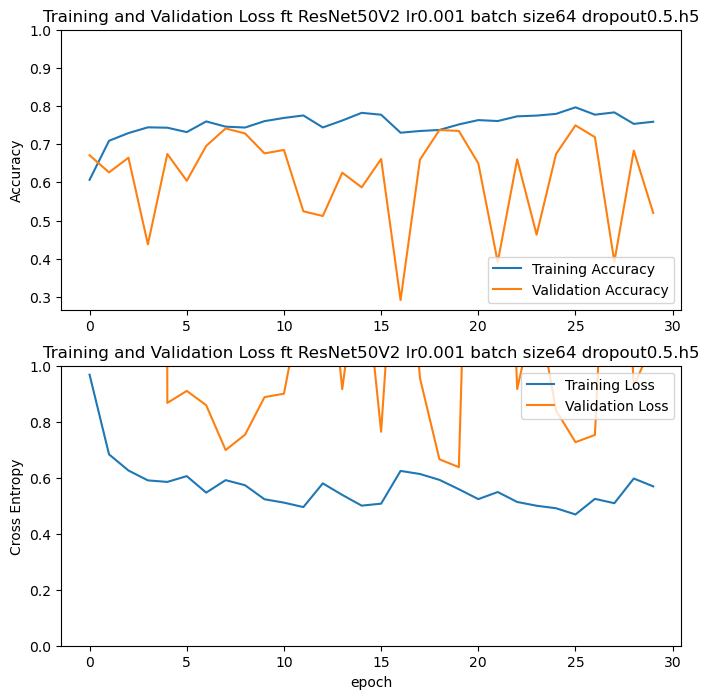

39/39 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0       0.65      0.72      0.68       208
           1       0.59      0.29      0.39       250
           2       0.82      0.93      0.87       767

    accuracy                           0.76      1225
   macro avg       0.69      0.65      0.65      1225
weighted avg       0.74      0.76      0.74      1225



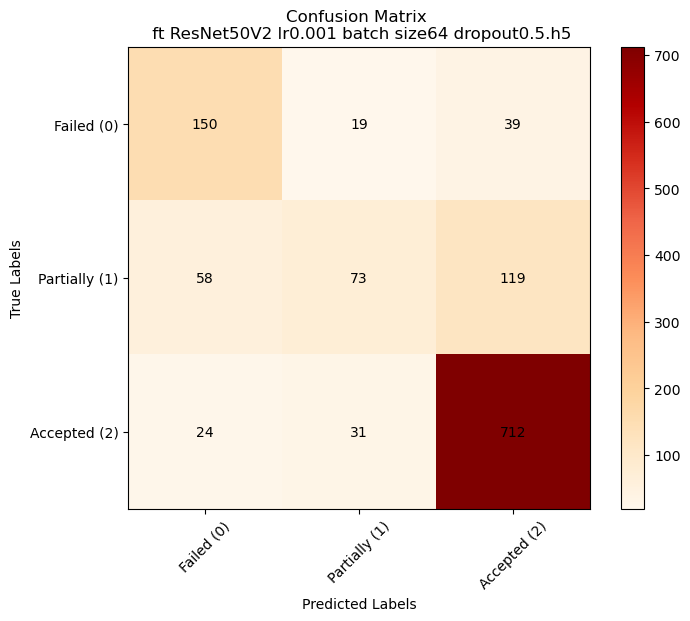

Running: 
 learning rate:0.001, batch size: 32 with dropout: 0.2 for epochs: 100
Epoch 1/100
424/424 [==============================] - 15s 29ms/step - loss: 1.2702 - accuracy: 0.5193 - val_loss: 1.0051 - val_accuracy: 0.5535
Epoch 2/100
424/424 [==============================] - 11s 26ms/step - loss: 0.8369 - accuracy: 0.5776 - val_loss: 1.1508 - val_accuracy: 0.5094
Epoch 3/100
424/424 [==============================] - 11s 27ms/step - loss: 0.7856 - accuracy: 0.6155 - val_loss: 1.1555 - val_accuracy: 0.4571
Epoch 4/100
424/424 [==============================] - 12s 28ms/step - loss: 0.7574 - accuracy: 0.6283 - val_loss: 0.9371 - val_accuracy: 0.5804
Epoch 5/100
424/424 [==============================] - 12s 27ms/step - loss: 0.7245 - accuracy: 0.6430 - val_loss: 0.9573 - val_accuracy: 0.5869
Epoch 6/100
424/424 [==============================] - 11s 26ms/step - loss: 0.7081 - accuracy: 0.6531 - val_loss: 1.0913 - val_accuracy: 0.5437
Epoch 7/100
424/424 [============================

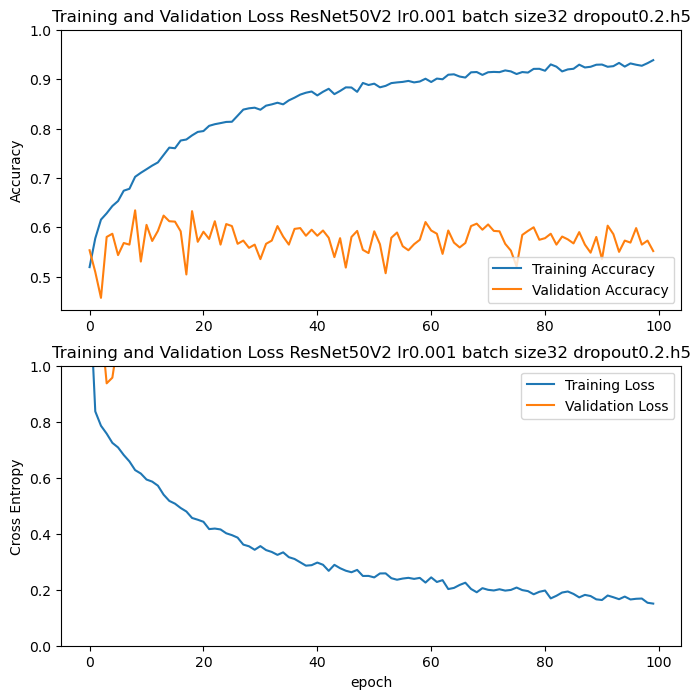

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.49      0.46      0.48       208
           1       0.32      0.49      0.38       250
           2       0.82      0.68      0.75       767

    accuracy                           0.61      1225
   macro avg       0.54      0.55      0.54      1225
weighted avg       0.66      0.61      0.63      1225



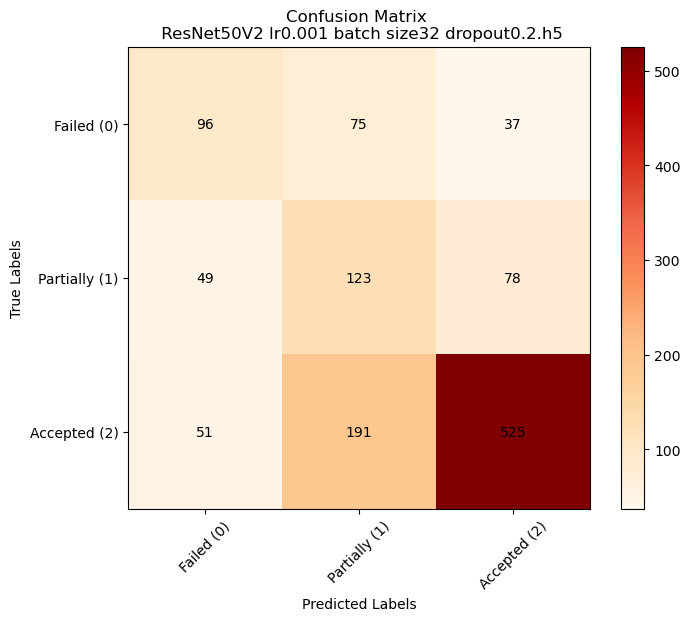

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

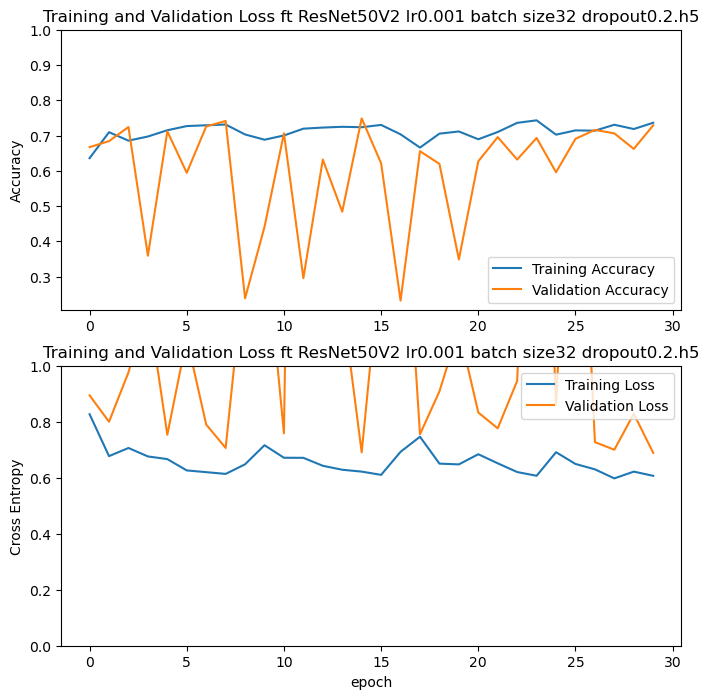

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       208
           1       0.57      0.28      0.37       250
           2       0.80      0.95      0.87       767

    accuracy                           0.76      1225
   macro avg       0.70      0.63      0.65      1225
weighted avg       0.74      0.76      0.74      1225



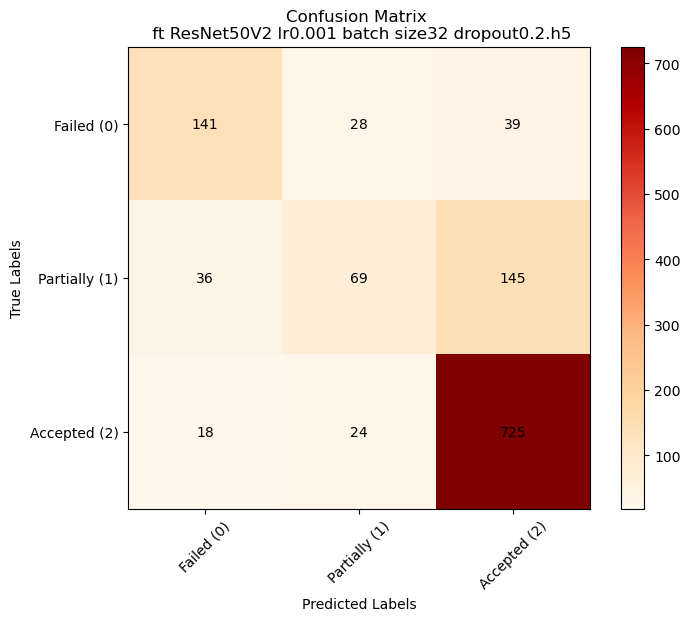

Running: 
 learning rate:0.001, batch size: 32 with dropout: 0.5 for epochs: 100
Epoch 1/100
424/424 [==============================] - 15s 29ms/step - loss: 1.4054 - accuracy: 0.4977 - val_loss: 1.0552 - val_accuracy: 0.4784
Epoch 2/100
424/424 [==============================] - 11s 26ms/step - loss: 0.8943 - accuracy: 0.5367 - val_loss: 1.0662 - val_accuracy: 0.4555
Epoch 3/100
424/424 [==============================] - 12s 27ms/step - loss: 0.8542 - accuracy: 0.5664 - val_loss: 0.9722 - val_accuracy: 0.5412
Epoch 4/100
424/424 [==============================] - 12s 27ms/step - loss: 0.8385 - accuracy: 0.5761 - val_loss: 0.9248 - val_accuracy: 0.5535
Epoch 5/100
424/424 [==============================] - 11s 26ms/step - loss: 0.8290 - accuracy: 0.5761 - val_loss: 0.9919 - val_accuracy: 0.5053
Epoch 6/100
424/424 [==============================] - 11s 26ms/step - loss: 0.8224 - accuracy: 0.5791 - val_loss: 0.9828 - val_accuracy: 0.5347
Epoch 7/100
424/424 [============================

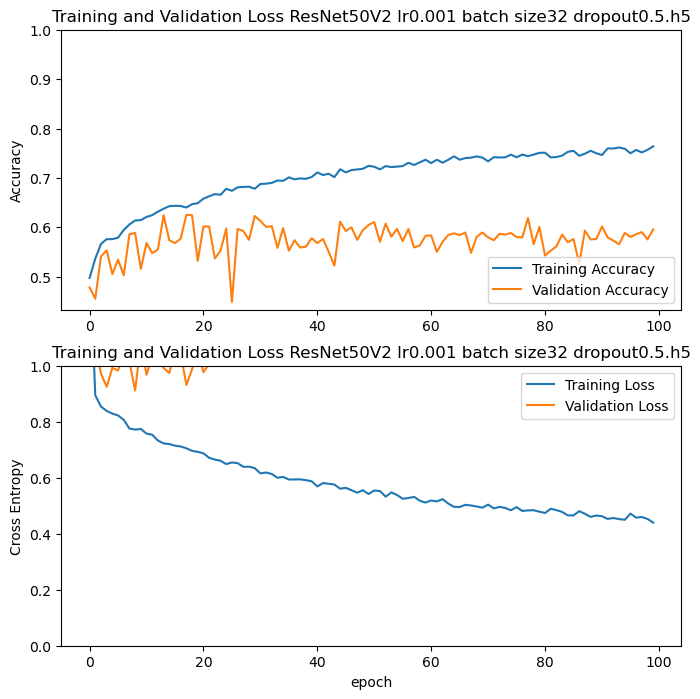

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.53      0.25      0.34       208
           1       0.32      0.58      0.42       250
           2       0.81      0.72      0.76       767

    accuracy                           0.61      1225
   macro avg       0.56      0.52      0.50      1225
weighted avg       0.66      0.61      0.62      1225



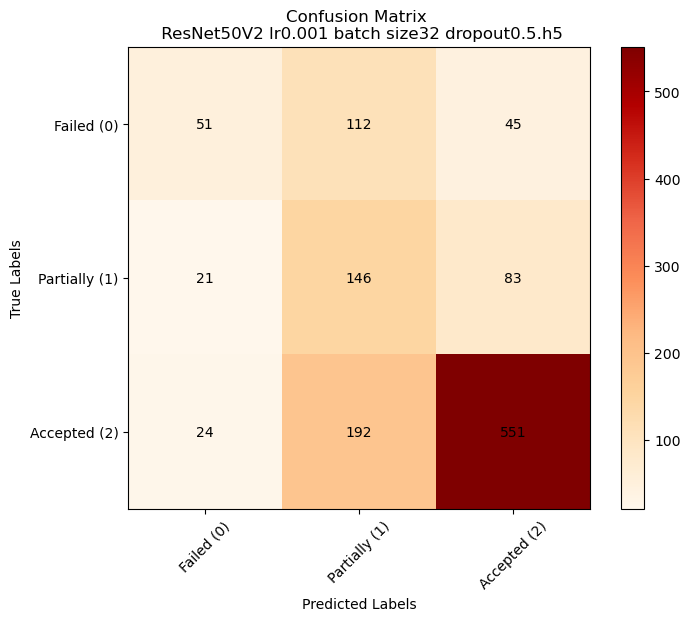

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_3 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

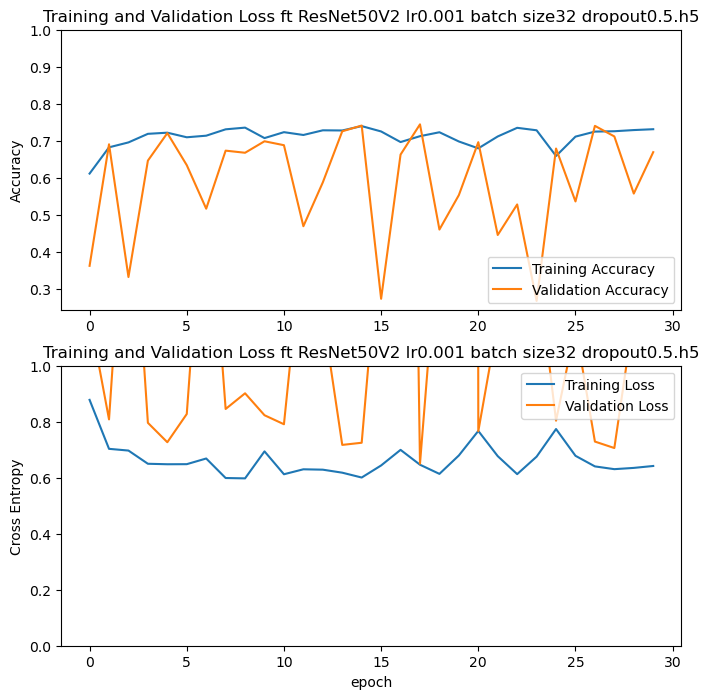

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       208
           1       0.56      0.41      0.47       250
           2       0.82      0.91      0.87       767

    accuracy                           0.77      1225
   macro avg       0.71      0.67      0.69      1225
weighted avg       0.76      0.77      0.76      1225



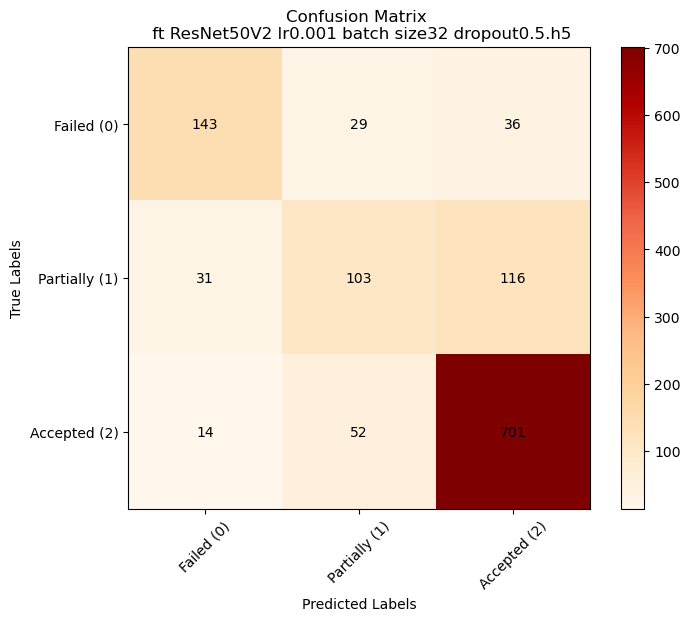

Running: 
 learning rate:0.001, batch size: 16 with dropout: 0.2 for epochs: 100
Epoch 1/100
848/848 [==============================] - 16s 17ms/step - loss: 1.1713 - accuracy: 0.5194 - val_loss: 1.1191 - val_accuracy: 0.5216
Epoch 2/100
848/848 [==============================] - 13s 16ms/step - loss: 0.8442 - accuracy: 0.5721 - val_loss: 0.8473 - val_accuracy: 0.6220
Epoch 3/100
848/848 [==============================] - 13s 16ms/step - loss: 0.8154 - accuracy: 0.5900 - val_loss: 1.0204 - val_accuracy: 0.5771
Epoch 4/100
848/848 [==============================] - 13s 16ms/step - loss: 0.7858 - accuracy: 0.5996 - val_loss: 1.0921 - val_accuracy: 0.5151
Epoch 5/100
848/848 [==============================] - 13s 16ms/step - loss: 0.7600 - accuracy: 0.6244 - val_loss: 0.9729 - val_accuracy: 0.5747
Epoch 6/100
848/848 [==============================] - 13s 16ms/step - loss: 0.7389 - accuracy: 0.6315 - val_loss: 0.9134 - val_accuracy: 0.6016
Epoch 7/100
848/848 [============================

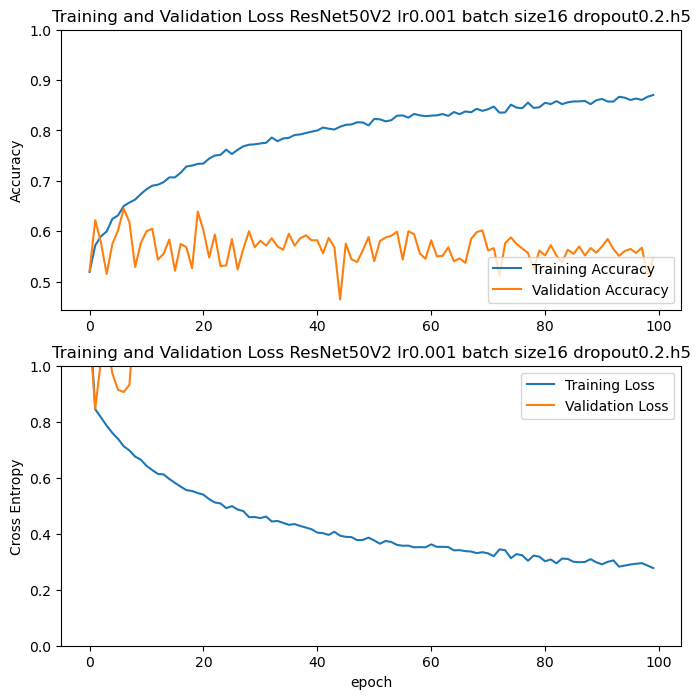

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.52      0.39      0.45       208
           1       0.34      0.52      0.41       250
           2       0.82      0.74      0.78       767

    accuracy                           0.63      1225
   macro avg       0.56      0.55      0.55      1225
weighted avg       0.67      0.63      0.65      1225



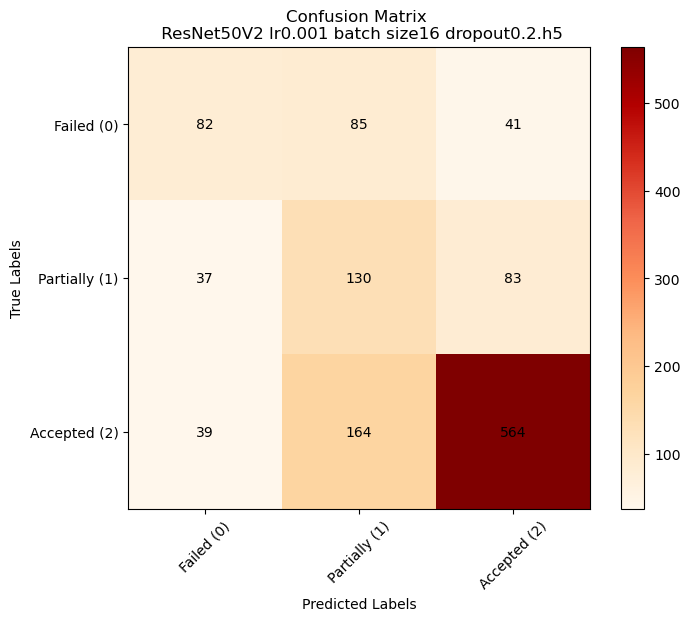

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_4 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

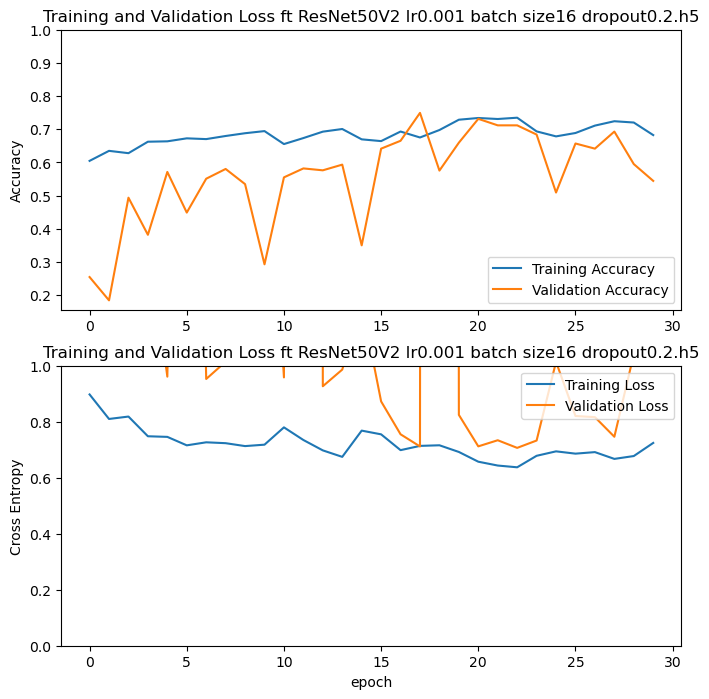

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       208
           1       0.61      0.30      0.40       250
           2       0.81      0.93      0.87       767

    accuracy                           0.78      1225
   macro avg       0.71      0.67      0.67      1225
weighted avg       0.76      0.78      0.75      1225



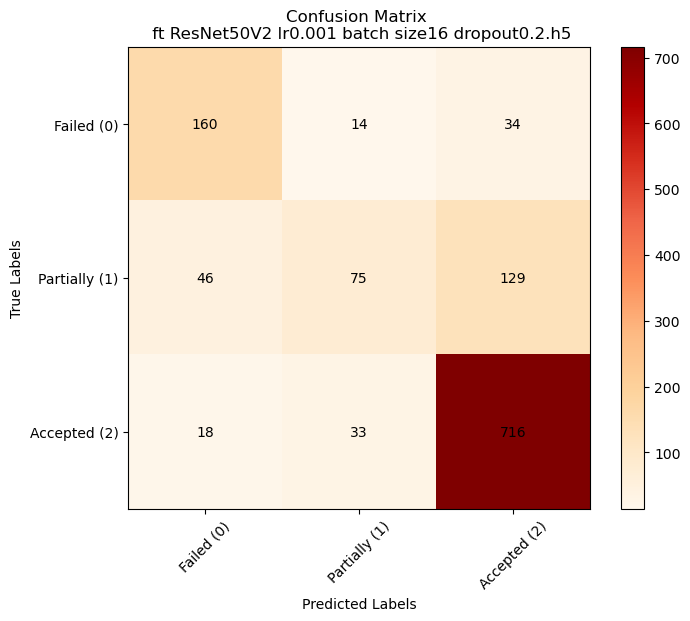

Running: 
 learning rate:0.001, batch size: 16 with dropout: 0.5 for epochs: 100
Epoch 1/100
848/848 [==============================] - 16s 17ms/step - loss: 1.3173 - accuracy: 0.4911 - val_loss: 1.1518 - val_accuracy: 0.3812
Epoch 2/100
848/848 [==============================] - 14s 16ms/step - loss: 0.9119 - accuracy: 0.5228 - val_loss: 1.1572 - val_accuracy: 0.4367
Epoch 3/100
848/848 [==============================] - 14s 16ms/step - loss: 0.8804 - accuracy: 0.5430 - val_loss: 1.0085 - val_accuracy: 0.5437
Epoch 4/100
848/848 [==============================] - 13s 16ms/step - loss: 0.8669 - accuracy: 0.5516 - val_loss: 1.1908 - val_accuracy: 0.4049
Epoch 5/100
848/848 [==============================] - 13s 16ms/step - loss: 0.8511 - accuracy: 0.5553 - val_loss: 1.0781 - val_accuracy: 0.5420
Epoch 6/100
848/848 [==============================] - 13s 16ms/step - loss: 0.8381 - accuracy: 0.5649 - val_loss: 0.9439 - val_accuracy: 0.5404
Epoch 7/100
848/848 [============================

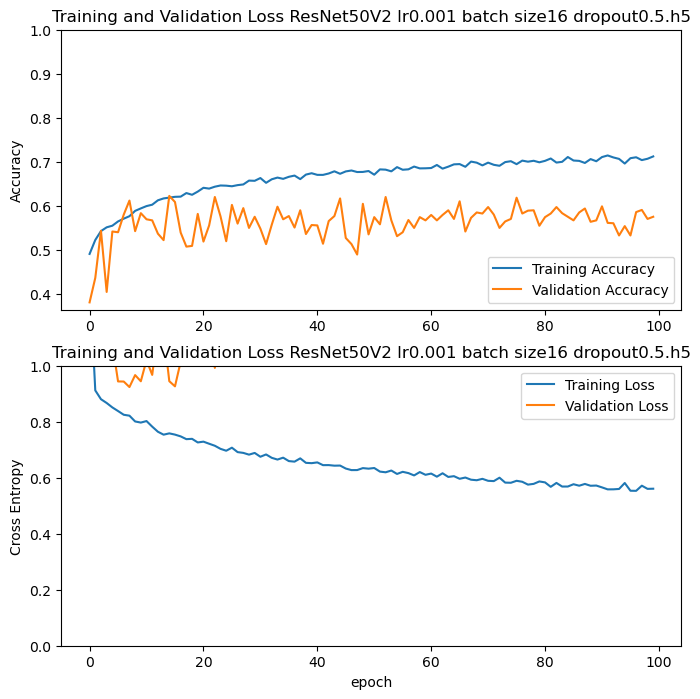

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.54      0.46      0.50       208
           1       0.29      0.52      0.37       250
           2       0.84      0.65      0.73       767

    accuracy                           0.59      1225
   macro avg       0.56      0.55      0.53      1225
weighted avg       0.67      0.59      0.62      1225



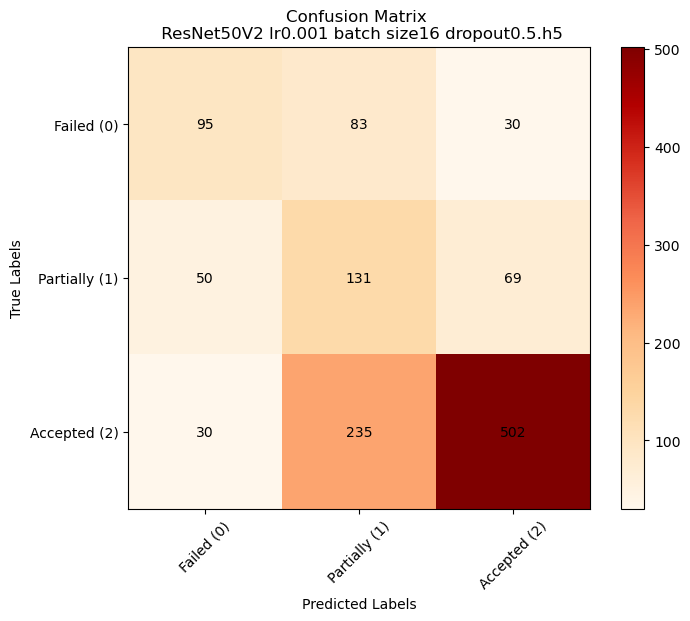

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_5 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

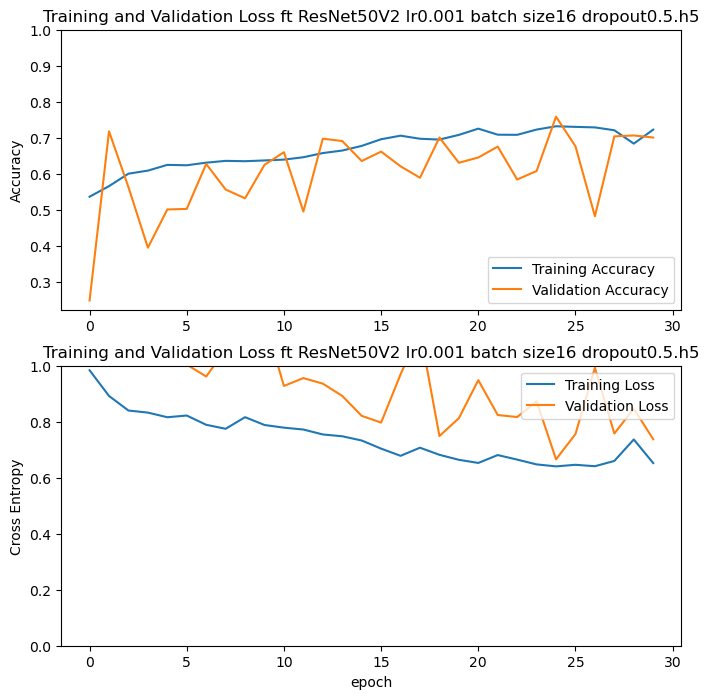

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.67      0.64      0.66       208
           1       0.54      0.20      0.29       250
           2       0.79      0.96      0.86       767

    accuracy                           0.75      1225
   macro avg       0.67      0.60      0.60      1225
weighted avg       0.72      0.75      0.71      1225



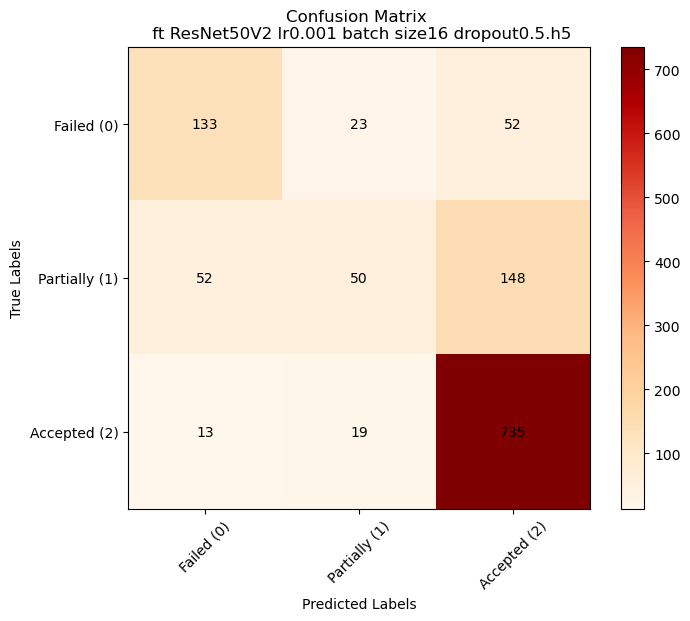

In [16]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.001]
batch_size = [64,32,16]
dropouts = [0.2, 0.5]

####################################################################################################################
#           We define our model specific parameters

model_name = "ResNet50V2" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running {len(learning_rate)*len(batch_size)*len(dropouts)} possible models with learning rates:{learning_rate} and batch sizes: {batch_size} with dropouts: {dropouts} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
        for d in dropouts:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} with dropout: {d} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.ResNet50V2(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalMaxPool2D(),
                tf.keras.layers.Dense(512, activation='relu'),  
                tf.keras.layers.Dropout(d),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)  

            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)  

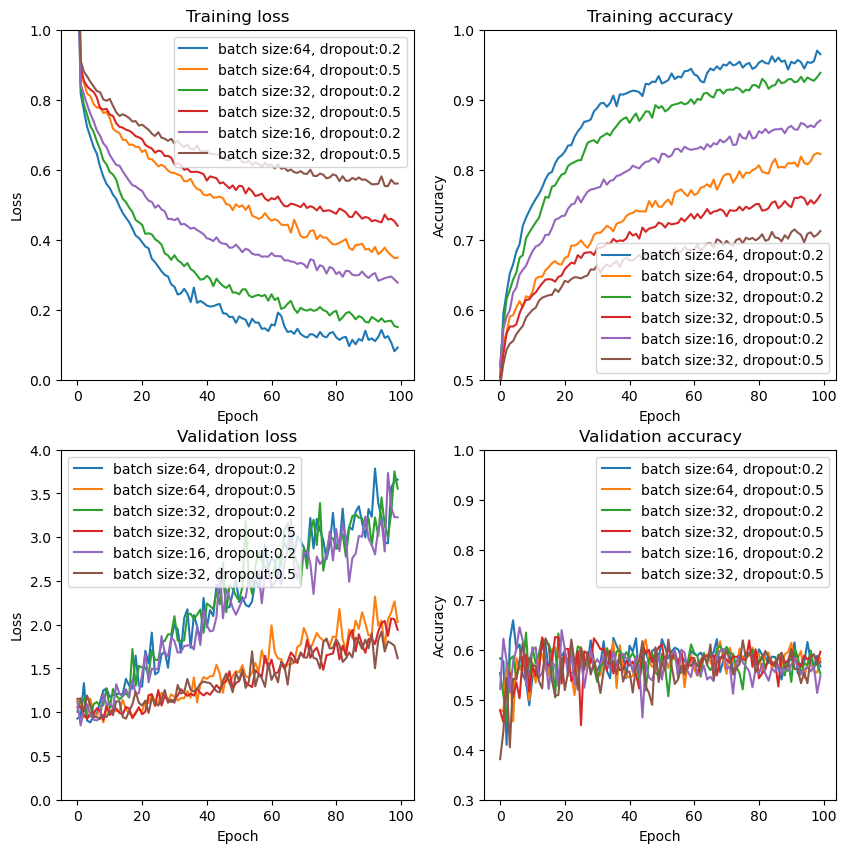

In [17]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(histories[0].history['loss'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['loss'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['loss'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['loss'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['loss'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['loss'], label='batch size:32, dropout:0.5')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(histories[0].history['accuracy'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['accuracy'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['accuracy'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['accuracy'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['accuracy'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['accuracy'], label='batch size:32, dropout:0.5')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(histories[0].history['val_loss'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['val_loss'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['val_loss'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['val_loss'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['val_loss'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['val_loss'], label='batch size:32, dropout:0.5')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(histories[0].history['val_accuracy'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['val_accuracy'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['val_accuracy'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['val_accuracy'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['val_accuracy'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['val_accuracy'], label='batch size:32, dropout:0.5')
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

plt.savefig('fintuned_metrics.png')
plt.show()

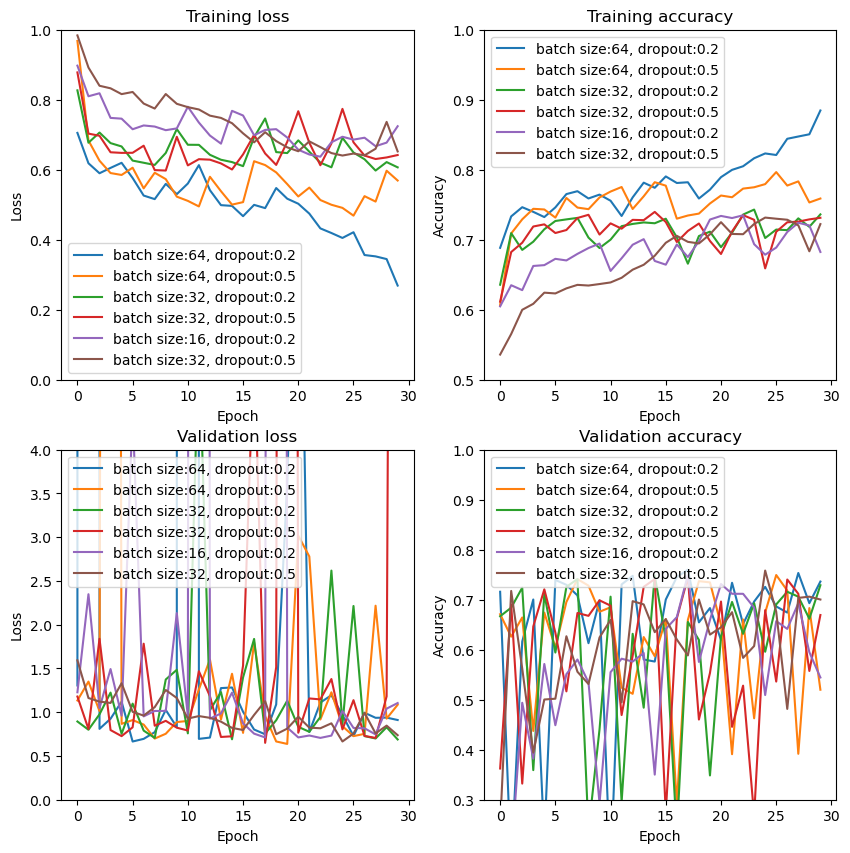

In [18]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(ft_histories[0].history['loss'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['loss'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['loss'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['loss'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['loss'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['loss'], label='batch size:32, dropout:0.5')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(ft_histories[0].history['accuracy'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['accuracy'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['accuracy'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['accuracy'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['accuracy'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['accuracy'], label='batch size:32, dropout:0.5')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(ft_histories[0].history['val_loss'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['val_loss'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['val_loss'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['val_loss'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['val_loss'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['val_loss'], label='batch size:32, dropout:0.5')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(ft_histories[0].history['val_accuracy'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['val_accuracy'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['val_accuracy'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['val_accuracy'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['val_accuracy'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['val_accuracy'], label='batch size:32, dropout:0.5')
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

plt.savefig('fintuned_metrics.png')
plt.show()

### For 0.01 learning rate

In [21]:
histories = []
name = []

ft_histories = []
ft_name = []

Running 6 possible models with learning rates:[0.01] and batch sizes: [64, 32, 16] with dropouts: [0.2, 0.5] for epochs: 100
Running: 
 learning rate:0.01, batch size: 64 with dropout: 0.2 for epochs: 100
Epoch 1/100
212/212 [==============================] - 18s 48ms/step - loss: 4.9323 - accuracy: 0.4985 - val_loss: 1.1448 - val_accuracy: 0.4367
Epoch 2/100
212/212 [==============================] - 9s 44ms/step - loss: 0.8617 - accuracy: 0.5676 - val_loss: 1.1267 - val_accuracy: 0.4171
Epoch 3/100
212/212 [==============================] - 10s 45ms/step - loss: 0.8402 - accuracy: 0.5769 - val_loss: 0.9623 - val_accuracy: 0.5273
Epoch 4/100
212/212 [==============================] - 9s 43ms/step - loss: 0.8238 - accuracy: 0.5921 - val_loss: 0.9979 - val_accuracy: 0.4955
Epoch 5/100
212/212 [==============================] - 9s 44ms/step - loss: 0.8375 - accuracy: 0.5917 - val_loss: 1.0230 - val_accuracy: 0.5298
Epoch 6/100
212/212 [==============================] - 9s 44ms/step - los

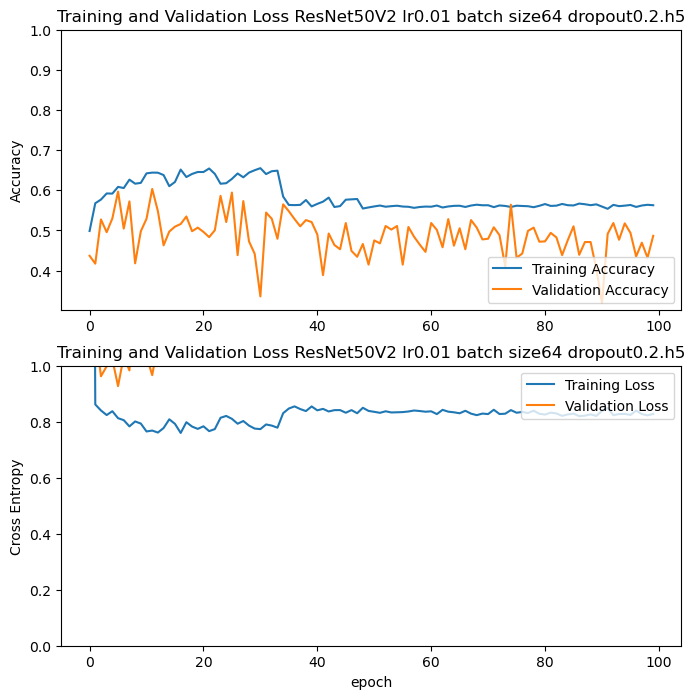

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.55      0.40      0.47       208
           1       0.31      0.60      0.41       250
           2       0.85      0.64      0.73       767

    accuracy                           0.59      1225
   macro avg       0.57      0.55      0.53      1225
weighted avg       0.69      0.59      0.62      1225



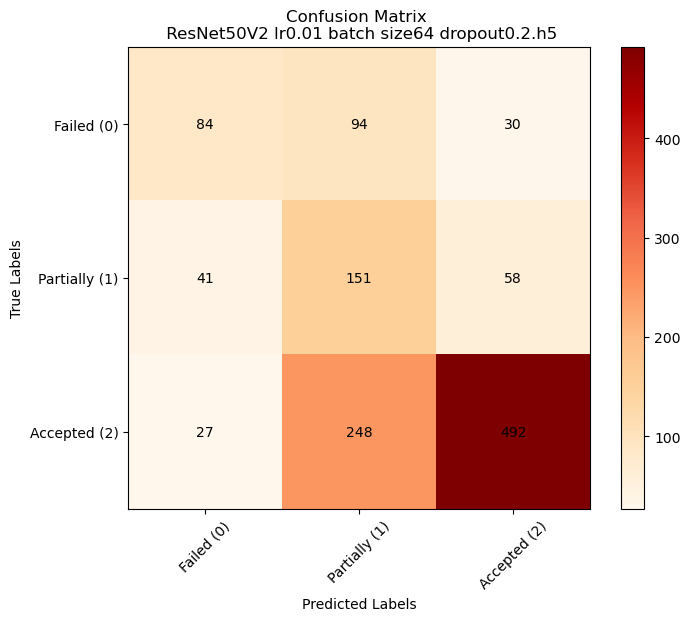

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_______________________________________

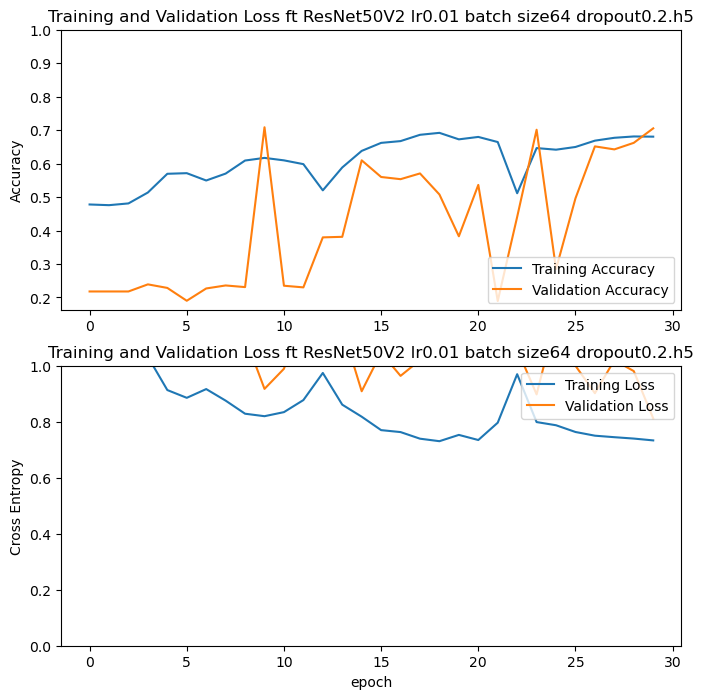

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.73      0.41      0.52       208
           1       0.39      0.22      0.28       250
           2       0.77      0.97      0.86       767

    accuracy                           0.72      1225
   macro avg       0.63      0.53      0.56      1225
weighted avg       0.69      0.72      0.69      1225



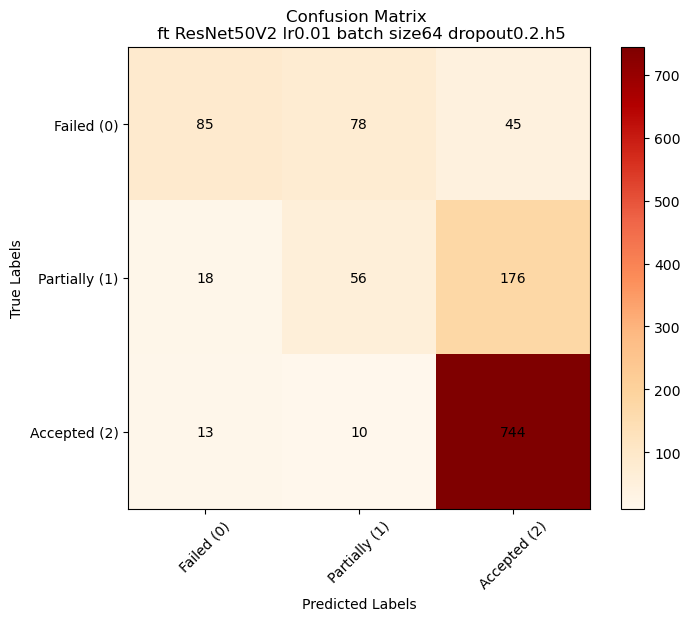

Running: 
 learning rate:0.01, batch size: 64 with dropout: 0.5 for epochs: 100
Epoch 1/100
212/212 [==============================] - 12s 48ms/step - loss: 6.2603 - accuracy: 0.4770 - val_loss: 1.3368 - val_accuracy: 0.2318
Epoch 2/100
212/212 [==============================] - 9s 44ms/step - loss: 0.9806 - accuracy: 0.4904 - val_loss: 1.4079 - val_accuracy: 0.2245
Epoch 3/100
212/212 [==============================] - 10s 45ms/step - loss: 0.9696 - accuracy: 0.4847 - val_loss: 1.2782 - val_accuracy: 0.2327
Epoch 4/100
212/212 [==============================] - 9s 44ms/step - loss: 0.9657 - accuracy: 0.4914 - val_loss: 1.2559 - val_accuracy: 0.2261
Epoch 5/100
212/212 [==============================] - 9s 44ms/step - loss: 0.9765 - accuracy: 0.4895 - val_loss: 1.3068 - val_accuracy: 0.2188
Epoch 6/100
212/212 [==============================] - 9s 44ms/step - loss: 1.0118 - accuracy: 0.4770 - val_loss: 1.4757 - val_accuracy: 0.2188
Epoch 7/100
212/212 [==============================] -

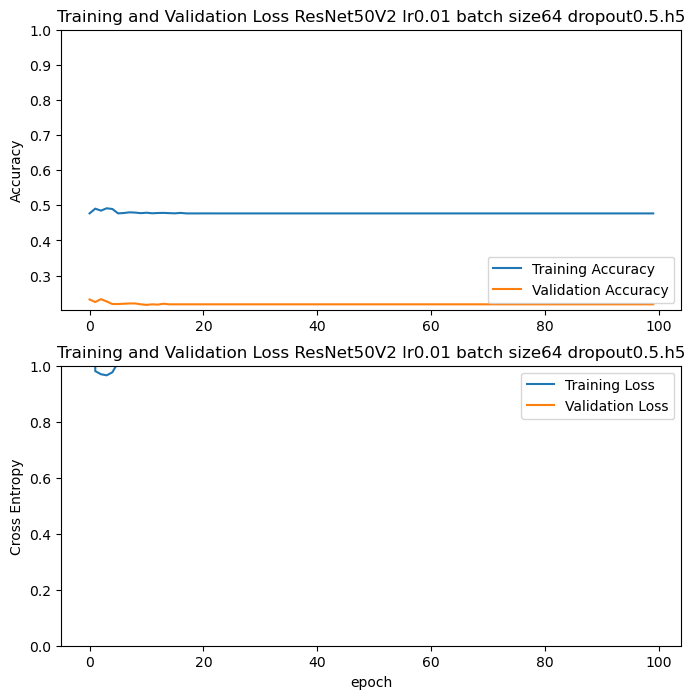

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.63      0.24      0.34       208
           1       0.20      0.94      0.34       250
           2       0.00      0.00      0.00       767

    accuracy                           0.23      1225
   macro avg       0.28      0.39      0.23      1225
weighted avg       0.15      0.23      0.13      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


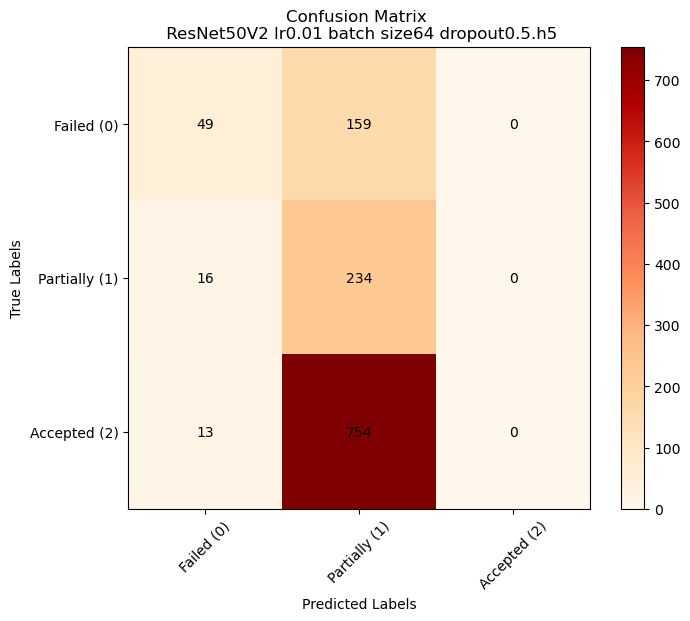

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

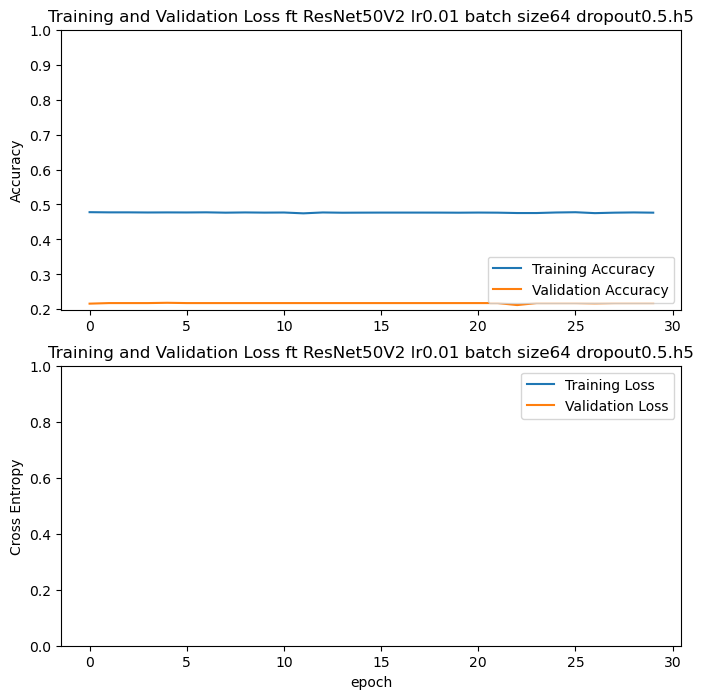

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.50      0.01      0.03       208
           1       0.20      1.00      0.34       250
           2       0.00      0.00      0.00       767

    accuracy                           0.21      1225
   macro avg       0.23      0.34      0.12      1225
weighted avg       0.13      0.21      0.07      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


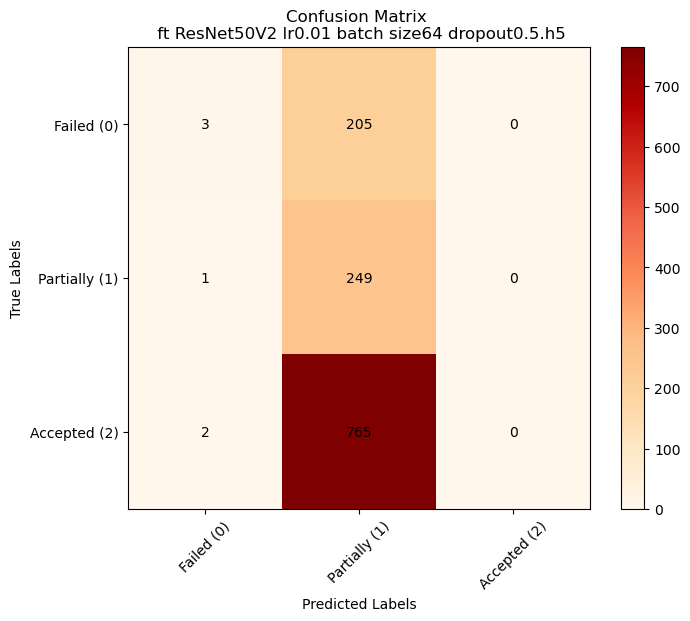

Running: 
 learning rate:0.01, batch size: 32 with dropout: 0.2 for epochs: 100
Epoch 1/100
424/424 [==============================] - 13s 27ms/step - loss: 2.6963 - accuracy: 0.4938 - val_loss: 0.9890 - val_accuracy: 0.5837
Epoch 2/100
424/424 [==============================] - 11s 25ms/step - loss: 0.9080 - accuracy: 0.5292 - val_loss: 1.1515 - val_accuracy: 0.4294
Epoch 3/100
424/424 [==============================] - 11s 25ms/step - loss: 0.9017 - accuracy: 0.5368 - val_loss: 1.1524 - val_accuracy: 0.4465
Epoch 4/100
424/424 [==============================] - 11s 26ms/step - loss: 0.9015 - accuracy: 0.5352 - val_loss: 0.9082 - val_accuracy: 0.5984
Epoch 5/100
424/424 [==============================] - 11s 25ms/step - loss: 0.9282 - accuracy: 0.5219 - val_loss: 1.5065 - val_accuracy: 0.2180
Epoch 6/100
424/424 [==============================] - 11s 25ms/step - loss: 0.9451 - accuracy: 0.5107 - val_loss: 1.0475 - val_accuracy: 0.4351
Epoch 7/100
424/424 [=============================

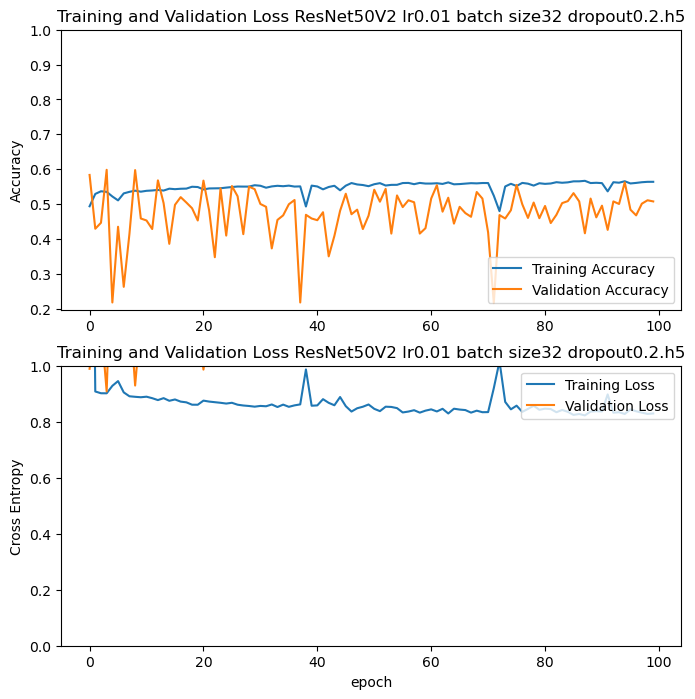

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.28      0.68      0.40       250
           2       0.81      0.66      0.73       767

    accuracy                           0.56      1225
   macro avg       0.37      0.45      0.38      1225
weighted avg       0.57      0.56      0.54      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


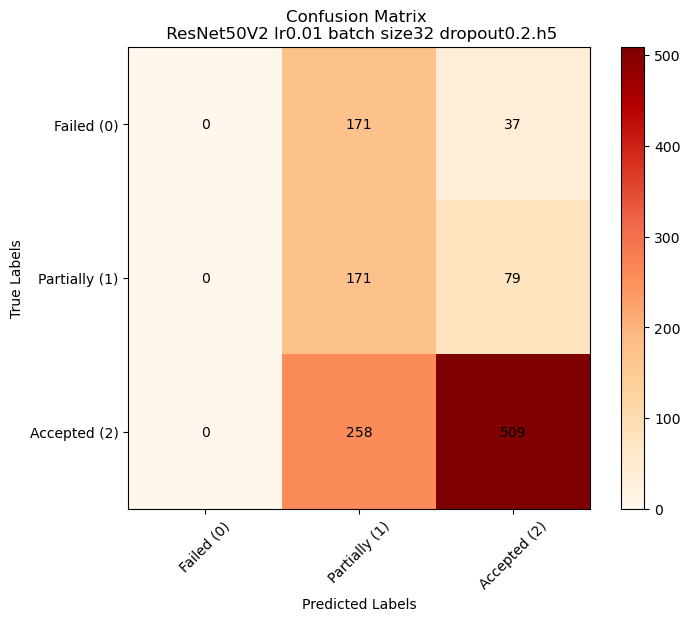

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

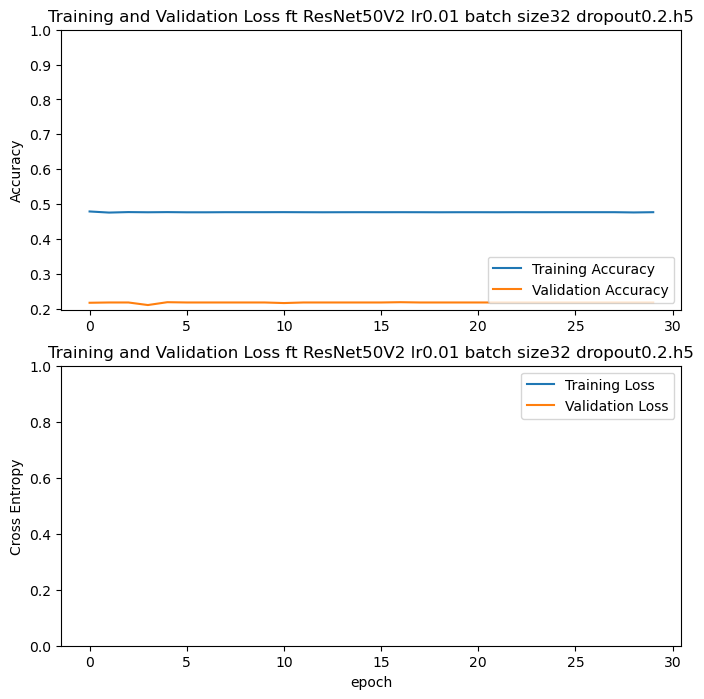

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.20      1.00      0.34       250
           2       0.00      0.00      0.00       767

    accuracy                           0.20      1225
   macro avg       0.07      0.33      0.11      1225
weighted avg       0.04      0.20      0.07      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


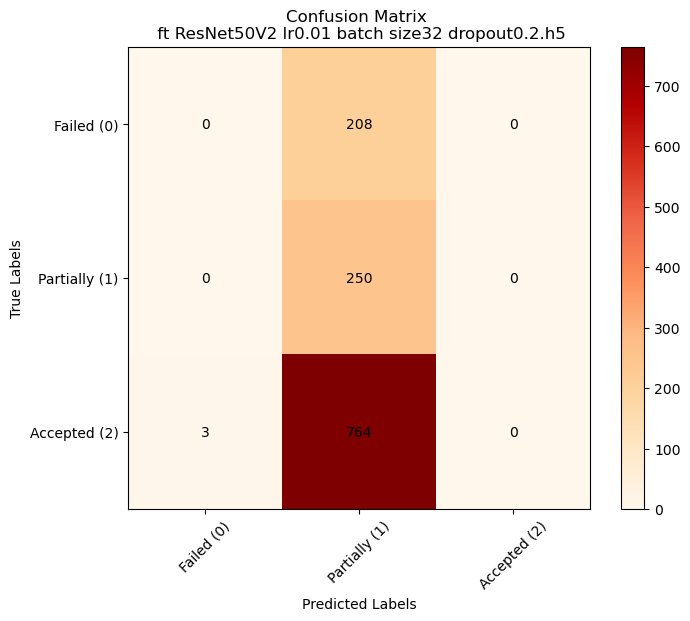

Running: 
 learning rate:0.01, batch size: 32 with dropout: 0.5 for epochs: 100
Epoch 1/100
424/424 [==============================] - 14s 27ms/step - loss: 3.1876 - accuracy: 0.4734 - val_loss: 1.2954 - val_accuracy: 0.2220
Epoch 2/100
424/424 [==============================] - 11s 26ms/step - loss: 0.9958 - accuracy: 0.4824 - val_loss: 1.2307 - val_accuracy: 0.3078
Epoch 3/100
424/424 [==============================] - 11s 25ms/step - loss: 1.0066 - accuracy: 0.4804 - val_loss: 1.2209 - val_accuracy: 0.3322
Epoch 4/100
424/424 [==============================] - 11s 25ms/step - loss: 1.0114 - accuracy: 0.4859 - val_loss: 1.4660 - val_accuracy: 0.2196
Epoch 5/100
424/424 [==============================] - 11s 25ms/step - loss: 1.0228 - accuracy: 0.4768 - val_loss: 1.4775 - val_accuracy: 0.2188
Epoch 6/100
424/424 [==============================] - 11s 25ms/step - loss: 1.0204 - accuracy: 0.4772 - val_loss: 1.4534 - val_accuracy: 0.2180
Epoch 7/100
424/424 [=============================

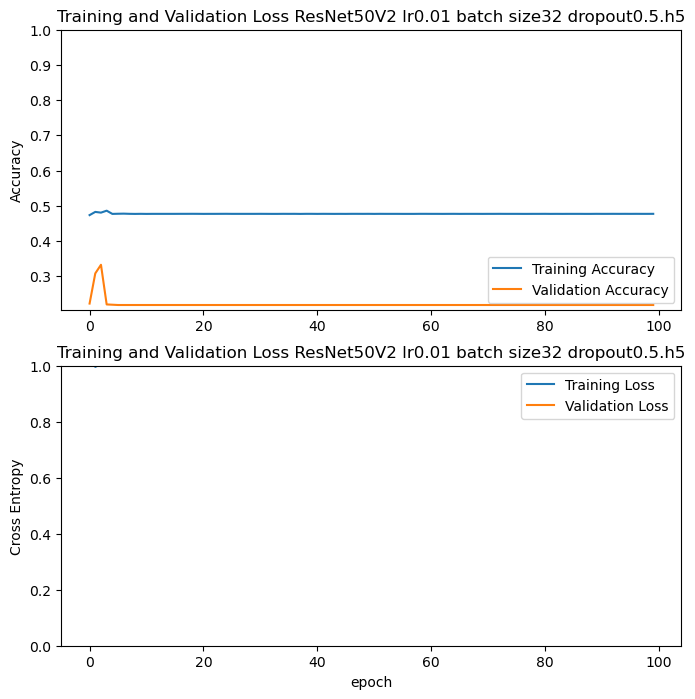

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.22      0.96      0.36       250
           2       0.90      0.16      0.27       767

    accuracy                           0.30      1225
   macro avg       0.37      0.37      0.21      1225
weighted avg       0.61      0.30      0.24      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


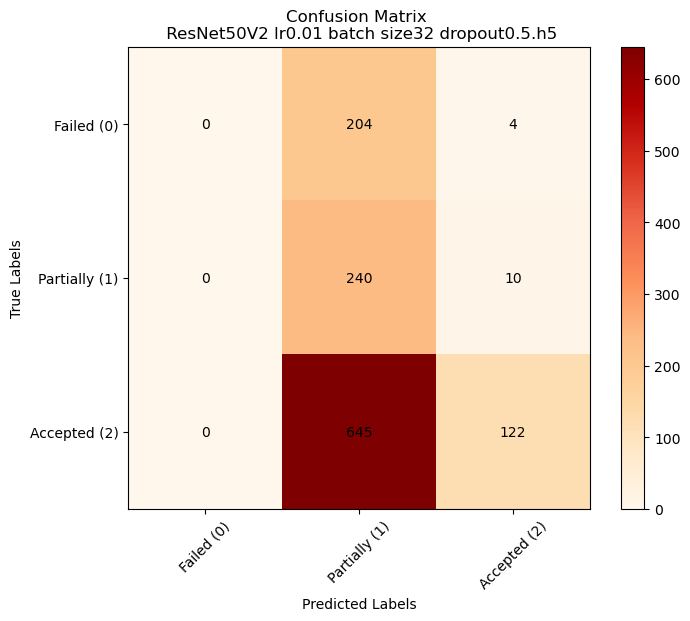

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_3 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

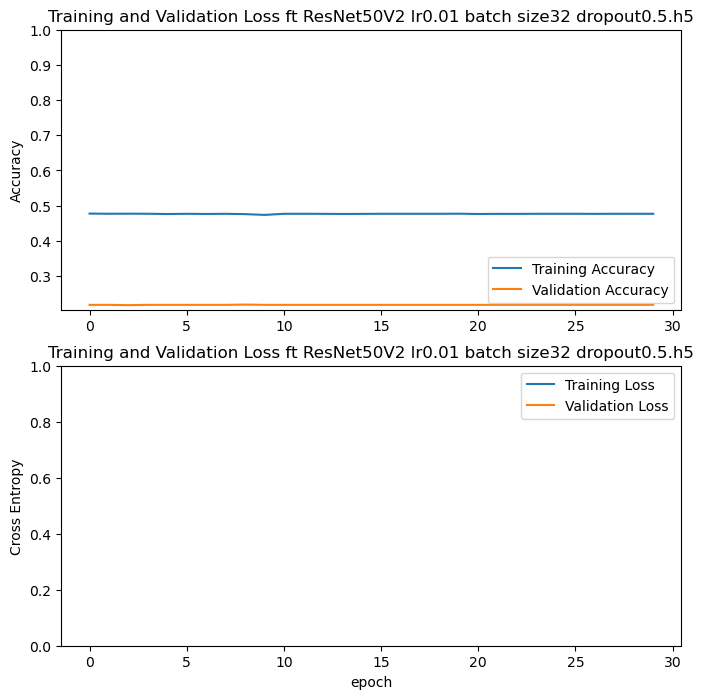

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.20      1.00      0.34       250
           2       0.00      0.00      0.00       767

    accuracy                           0.20      1225
   macro avg       0.07      0.33      0.11      1225
weighted avg       0.04      0.20      0.07      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


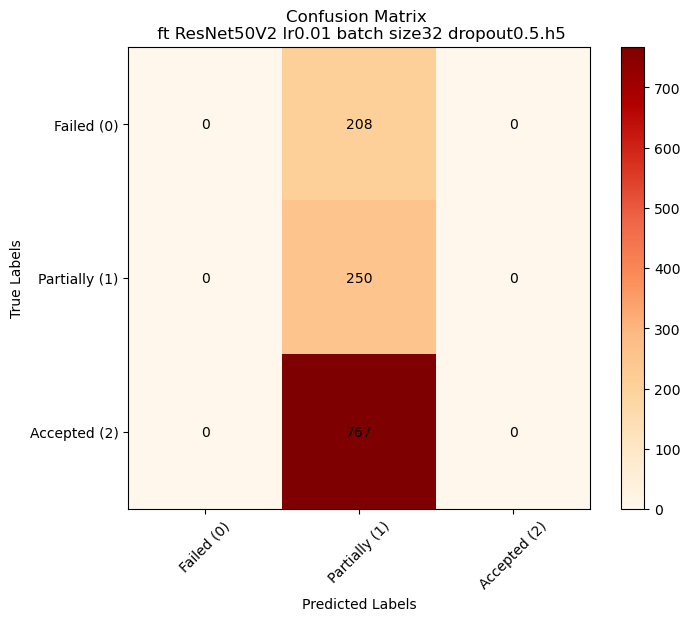

Running: 
 learning rate:0.01, batch size: 16 with dropout: 0.2 for epochs: 100
Epoch 1/100
848/848 [==============================] - 18s 19ms/step - loss: 2.0586 - accuracy: 0.4915 - val_loss: 1.1342 - val_accuracy: 0.4229
Epoch 2/100
848/848 [==============================] - 15s 18ms/step - loss: 0.9562 - accuracy: 0.5085 - val_loss: 0.9919 - val_accuracy: 0.5584
Epoch 3/100
848/848 [==============================] - 15s 17ms/step - loss: 0.9481 - accuracy: 0.5118 - val_loss: 1.3880 - val_accuracy: 0.2547
Epoch 4/100
848/848 [==============================] - 15s 17ms/step - loss: 0.9745 - accuracy: 0.5046 - val_loss: 1.4727 - val_accuracy: 0.2751
Epoch 5/100
848/848 [==============================] - 15s 17ms/step - loss: 1.0226 - accuracy: 0.4772 - val_loss: 1.4122 - val_accuracy: 0.2180
Epoch 6/100
848/848 [==============================] - 15s 17ms/step - loss: 1.0202 - accuracy: 0.4770 - val_loss: 1.4400 - val_accuracy: 0.2180
Epoch 7/100
848/848 [=============================

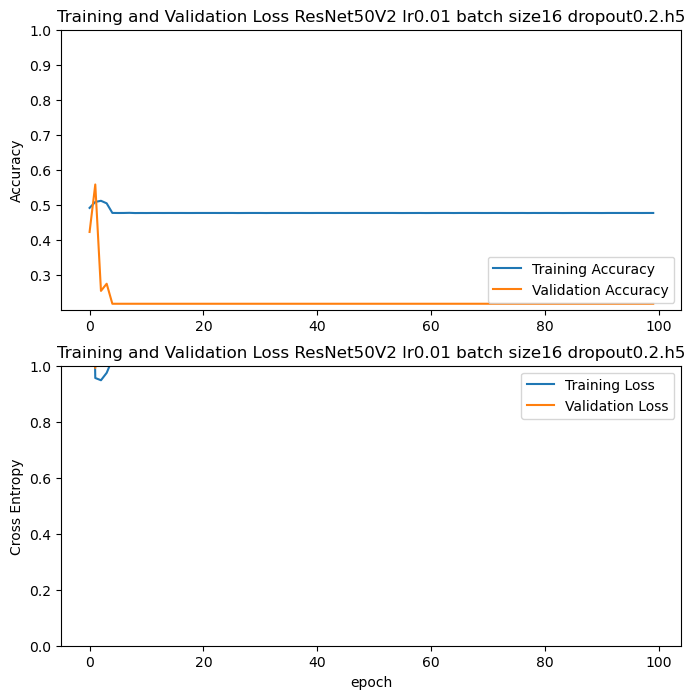

39/39 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.29      0.82      0.43       250
           2       0.87      0.58      0.69       767

    accuracy                           0.53      1225
   macro avg       0.39      0.47      0.37      1225
weighted avg       0.60      0.53      0.52      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


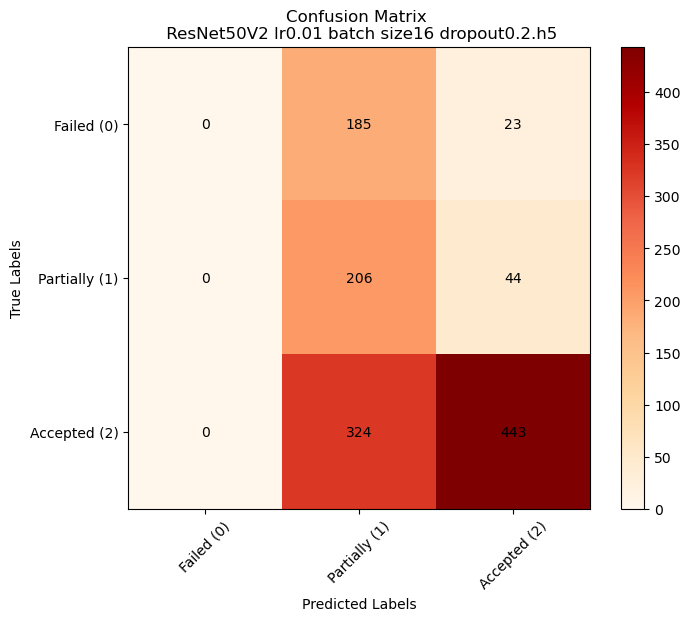

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_4 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

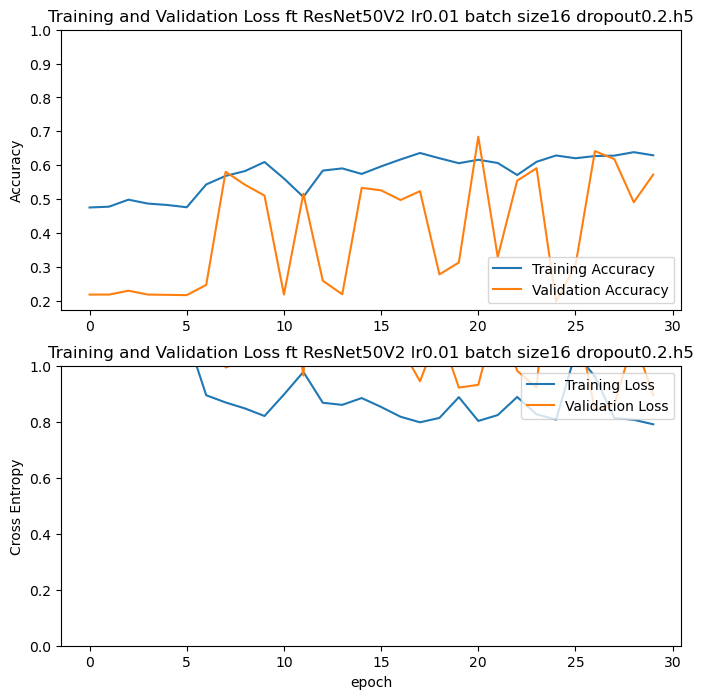

39/39 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.85      0.25      0.39       208
           1       0.35      0.67      0.46       250
           2       0.86      0.77      0.81       767

    accuracy                           0.66      1225
   macro avg       0.69      0.57      0.56      1225
weighted avg       0.75      0.66      0.67      1225



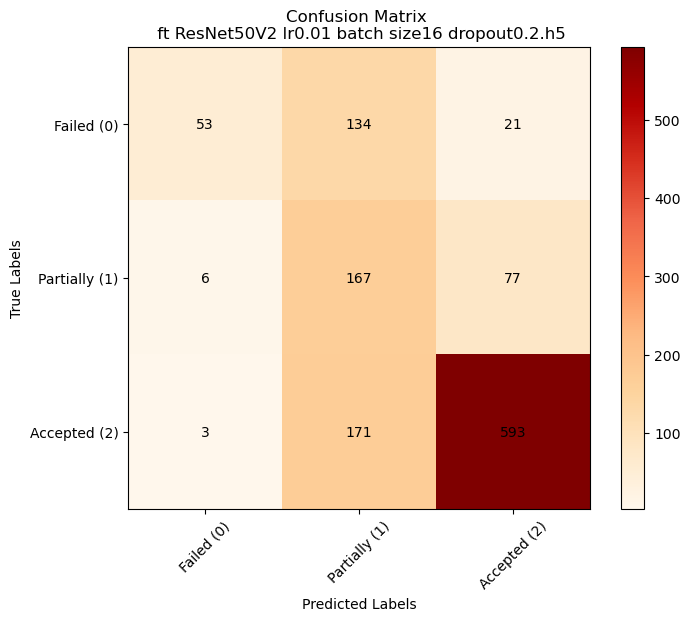

Running: 
 learning rate:0.01, batch size: 16 with dropout: 0.5 for epochs: 100
Epoch 1/100
848/848 [==============================] - 18s 18ms/step - loss: 2.9982 - accuracy: 0.4771 - val_loss: 1.4319 - val_accuracy: 0.2196
Epoch 2/100
848/848 [==============================] - 14s 17ms/step - loss: 1.0309 - accuracy: 0.4773 - val_loss: 1.3960 - val_accuracy: 0.2171
Epoch 3/100
848/848 [==============================] - 14s 17ms/step - loss: 1.0252 - accuracy: 0.4776 - val_loss: 1.5205 - val_accuracy: 0.2180
Epoch 4/100
848/848 [==============================] - 14s 17ms/step - loss: 1.0259 - accuracy: 0.4773 - val_loss: 1.4334 - val_accuracy: 0.2180
Epoch 5/100
848/848 [==============================] - 14s 17ms/step - loss: 1.0254 - accuracy: 0.4770 - val_loss: 1.4389 - val_accuracy: 0.2180
Epoch 6/100
848/848 [==============================] - 14s 17ms/step - loss: 1.0223 - accuracy: 0.4768 - val_loss: 1.4894 - val_accuracy: 0.2180
Epoch 7/100
848/848 [=============================

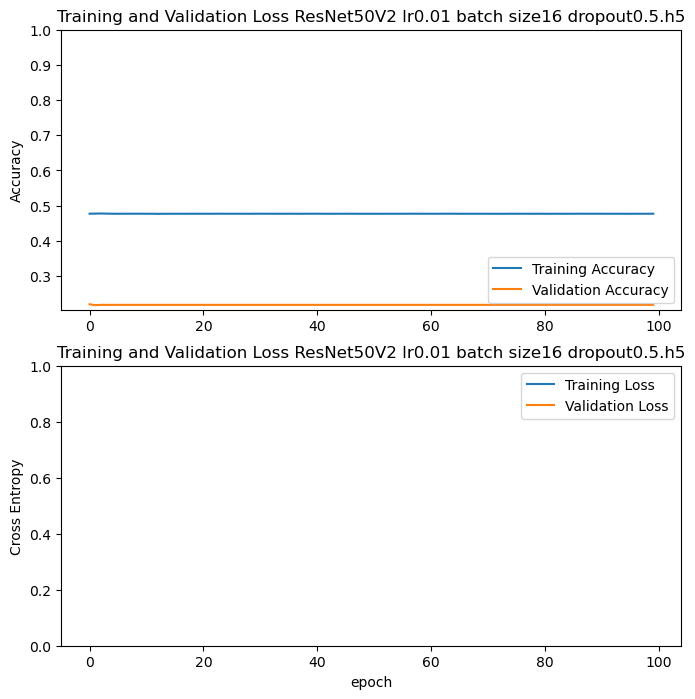

39/39 [==============================] - 3s 25ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.20      1.00      0.34       250
           2       0.00      0.00      0.00       767

    accuracy                           0.20      1225
   macro avg       0.07      0.33      0.11      1225
weighted avg       0.04      0.20      0.07      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


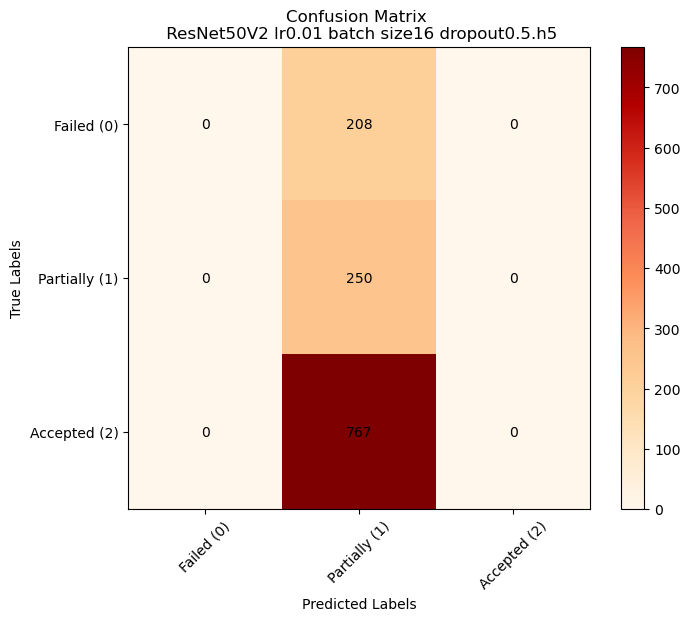

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d_5 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 24,615,427
Trainable params: 24,569,987
Non-trainable params: 45,440
_____________________________________

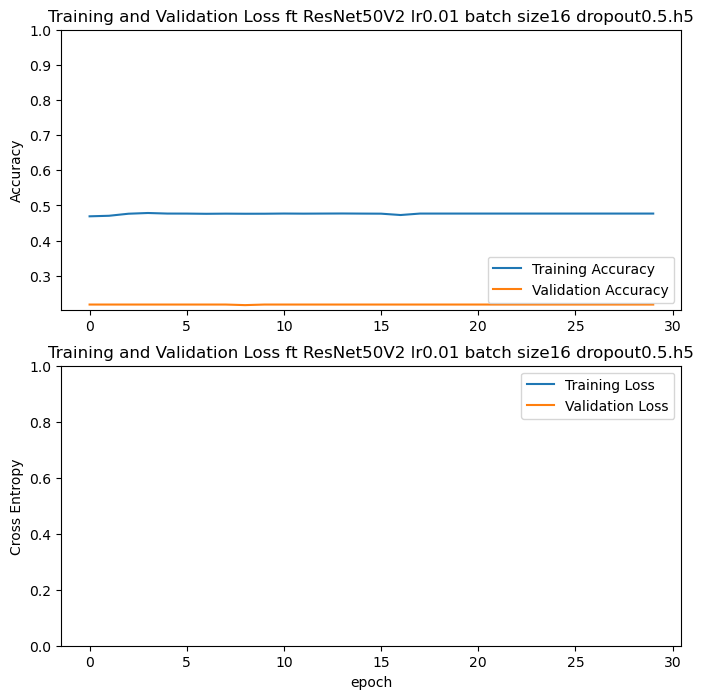

39/39 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       208
           1       0.20      1.00      0.34       250
           2       0.00      0.00      0.00       767

    accuracy                           0.20      1225
   macro avg       0.07      0.33      0.11      1225
weighted avg       0.04      0.20      0.07      1225



c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


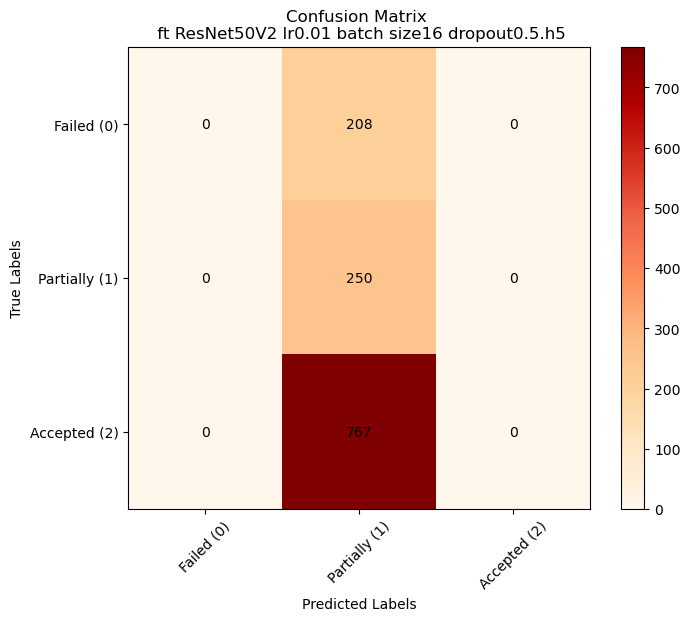

In [15]:
####################################################################################################################
#          We define our hyperparameters. everything is in the same cell for convenience

learning_rate = [0.01]
batch_size = [64,32,16]
dropouts = [0.2, 0.5]

####################################################################################################################
#           We define our model specific parameters

model_name = "ResNet50V2" # This is for our model saving names, you still have to change the keras.apllications.model name!
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)

####################################################################################################################
#           We print the number of models and state the hyperparameter search

print(f'Running {len(learning_rate)*len(batch_size)*len(dropouts)} possible models with learning rates:{learning_rate} and batch sizes: {batch_size} with dropouts: {dropouts} for epochs: {epochs}')

####################################################################################################################
#           We loop in our hyperparameters

for i in learning_rate:
    for j in batch_size:
        for d in dropouts:
            ####################################################################################################################
            #       We print the specific run
            print(f'Running: \n learning rate:{i}, batch size: {j} with dropout: {d} for epochs: {epochs}')

            ####################################################################################################################
            #       We import pre trained model from keras applications, weights are important for a pretrained model, 
            #       include top=False is to shave off the top dense layers, which we replace with our own. 

            base_model = keras.applications.ResNet50V2(weights='imagenet',  # Load weights pre-trained on ImageNet.
                                                  input_shape=input_shape,
                                                  include_top=False,# Do not include the ImageNet classifier at the top.
            ) 

            ####################################################################################################################
            #       We "Freeze" the base model to restrict training of the Convolutional layers in the base
            base_model.trainable = False

            ####################################################################################################################
            #       We define the new model in the sequential API of keras. 
            #       We add our own layers on top of the base model to train a classifier for our own dataset on top of the 
            #       "hopefully" generative base model  
            #       The top model dense layers are arbitrarily chosen.

            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalMaxPool2D(),
                tf.keras.layers.Dense(512, activation='relu'),  
                tf.keras.layers.Dropout(d),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])
            
            ####################################################################################################################
            #       We Compile our model

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            ####################################################################################################################
            #       We initiate a callback to save best performing model with the names of the gridsearch parameters.

            cp_filepath = '{} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')

            ####################################################################################################################
            #       We train the model by fitting and adding to history,
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            #       Load best model
            model = tf.keras.models.load_model(cp_filepath)


            ####################################################################################################################
            #       Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            ####################################################################################################################
            #       save model with acc for later investigaion

            model.save('model{} acc{}  lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))
            ####################################################################################################################
            #       print visualization of training metrics           
            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)  

            ####################################################################################################################
            #       We are now unfreezing the base layer and fine tune the whole model

            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


            cp_filepath = 'ft {} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)

            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')


            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)

                       # Load best model
            model = tf.keras.models.load_model(cp_filepath)

            # Evaluate model
            score = model.evaluate(X_test, y_test, verbose=0)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])

            model.save(' fintunedmodel{} acc{} lr{} batch size{} dropout{}.h5'.format(model_name,score[1], i,j,d))

            His_metrics(history, cp_filepath)
            Viz_metrics(X_test, y_test, model, cp_filepath)  

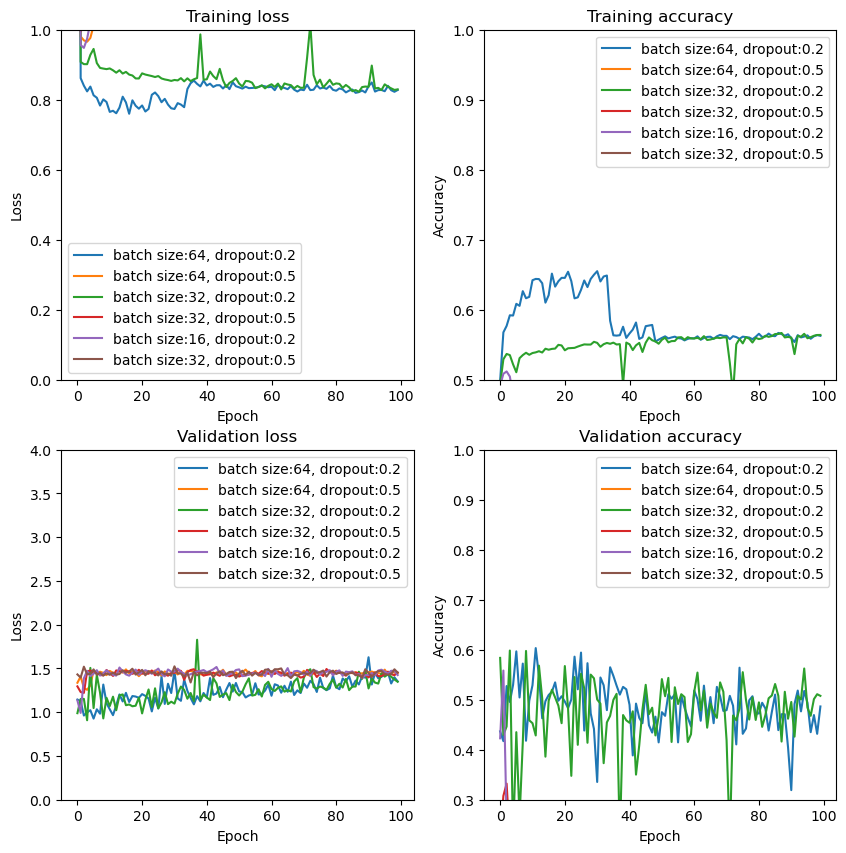

In [16]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(histories[0].history['loss'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['loss'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['loss'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['loss'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['loss'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['loss'], label='batch size:32, dropout:0.5')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(histories[0].history['accuracy'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['accuracy'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['accuracy'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['accuracy'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['accuracy'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['accuracy'], label='batch size:32, dropout:0.5')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(histories[0].history['val_loss'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['val_loss'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['val_loss'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['val_loss'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['val_loss'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['val_loss'], label='batch size:32, dropout:0.5')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(histories[0].history['val_accuracy'], label='batch size:64, dropout:0.2')
ax.plot(histories[1].history['val_accuracy'], label='batch size:64, dropout:0.5')
ax.plot(histories[2].history['val_accuracy'], label='batch size:32, dropout:0.2')
ax.plot(histories[3].history['val_accuracy'], label='batch size:32, dropout:0.5')
ax.plot(histories[4].history['val_accuracy'], label='batch size:16, dropout:0.2')
ax.plot(histories[5].history['val_accuracy'], label='batch size:32, dropout:0.5')
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

plt.savefig('fintuned_metrics.png')
plt.show()

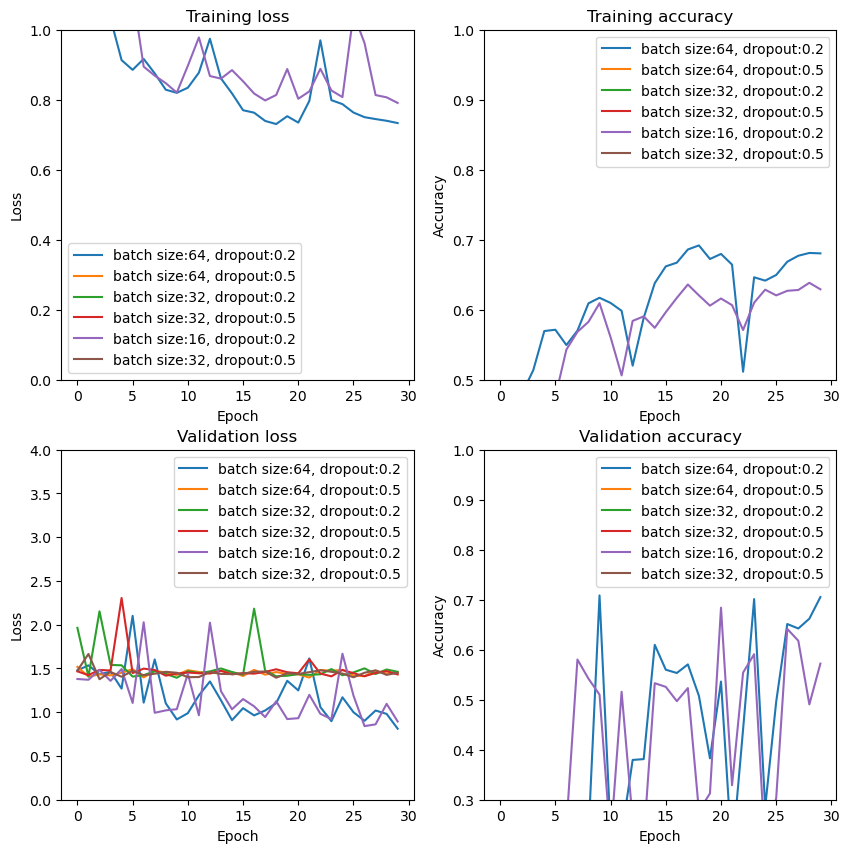

In [17]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(ft_histories[0].history['loss'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['loss'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['loss'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['loss'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['loss'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['loss'], label='batch size:32, dropout:0.5')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(ft_histories[0].history['accuracy'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['accuracy'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['accuracy'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['accuracy'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['accuracy'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['accuracy'], label='batch size:32, dropout:0.5')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(ft_histories[0].history['val_loss'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['val_loss'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['val_loss'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['val_loss'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['val_loss'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['val_loss'], label='batch size:32, dropout:0.5')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(ft_histories[0].history['val_accuracy'], label='batch size:64, dropout:0.2')
ax.plot(ft_histories[1].history['val_accuracy'], label='batch size:64, dropout:0.5')
ax.plot(ft_histories[2].history['val_accuracy'], label='batch size:32, dropout:0.2')
ax.plot(ft_histories[3].history['val_accuracy'], label='batch size:32, dropout:0.5')
ax.plot(ft_histories[4].history['val_accuracy'], label='batch size:16, dropout:0.2')
ax.plot(ft_histories[5].history['val_accuracy'], label='batch size:32, dropout:0.5')
plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

plt.savefig('fintuned_metrics.png')
plt.show()